# World Happiness Rankings Machine Learning Project

by Yassine Turki, Tudor Cardas, and Paula González Álvarez

First draft: In this project we will take the IMF's World Development Indicators data that we deem the most relevant to determine happiness and download it for multiple years and for the countries that are included in the World Happiness Reports. Then, we will clean our data and run a regression using the real Happiness Report Rankings to find a the weights we should include for each indicator. Then, we will apply that formula to our data and check how the ratings we find compare to those in the World Happiness Reports and check it against different years.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import KNNImputer 
import sklearn.tree
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


## Preliminary Part: Original Happiness Data

In [90]:
#Loading data from happiness (to have our "Y") + extracting only the column of interest, i.e Score

h2015=pd.read_csv("2015.csv")
h2016=pd.read_csv("2016.csv")
h2017=pd.read_csv("2017.csv")
h2017.at[55,"Country"]="Hong Kong"
h2018=pd.read_csv("2018.csv")
h2019=pd.read_csv("2019.csv")
h2020=pd.read_csv("2020.csv")
h2021=pd.read_csv("2021.csv")
# h2022=pd.read_csv("2022.csv").sort_values(by=['Country'])["Happiness score"]

years=[h2015,h2016,h2017,h2018,h2019,h2020,h2021]

In [91]:
#We make sure that all the datasets have the same feature / feature names

#2015
h2015.drop(columns=["Happiness Rank","Standard Error","Family","Region"],axis=1, inplace=True)
h2015.drop(h2015.columns[-1],axis=1,inplace=True)

#2016
h2016.drop(columns=["Happiness Rank","Family","Region","Upper Confidence Interval","Lower Confidence Interval"],axis=1, inplace=True)
h2016.drop(h2016.columns[-1],axis=1,inplace=True)

#2017
h2017.drop(columns=["Happiness.Rank","Whisker.high","Whisker.low","Family","Dystopia.Residual"],axis=1,inplace=True)
h2017=h2017.rename(columns={"Happiness.Score":"Happiness Score","Economy..GDP.per.Capita.":"Economy (GDP per Capita)",
                            "Trust..Government.Corruption.":"Trust (Government Corruption)",
                            "Health..Life.Expectancy.":"Health (Life Expectancy)"})
#2018
                  
h2018.drop(columns=["Overall rank","Social support"],axis=1,inplace=True)
h2018=h2018.rename(columns={"Country or region":"Country",
                            "GDP per capita":"Economy (GDP per Capita)",
                           "Score":"Happiness Score",
                            "Healthy life expectancy":"Health (Life Expectancy)",
                           "Freedom to make life choices":"Freedom",
                           "Perceptions of corruption":"Trust (Government Corruption)"})

#2019
h2019.drop(columns=["Overall rank","Social support"],axis=1,inplace=True)
h2019=h2019.rename(columns={"Country or region":"Country","Score":"Happiness Score",
                      "GDP per capita":"Economy (GDP per Capita)",
                      "Freedom to make life choices":"Freedom",
                      "Perceptions of corruption":"Trust (Government Corruption)",
                    "Healthy life expectancy":"Health (Life Expectancy)"
                     })

#2020
h2020.drop(columns=["Regional indicator","Standard error of ladder score","upperwhisker","lowerwhisker",
                    "Social support","Logged GDP per capita","Explained by: Social support","Ladder score in Dystopia",
                   "Dystopia + residual","Freedom to make life choices",
                   "Healthy life expectancy","Generosity", "Perceptions of corruption"],axis=1,inplace=True)
h2020=h2020.rename(columns={"Country name":"Country",
                            "Ladder score":"Happiness Score",
                            "Explained by: Generosity":"Generosity",
                      "Explained by: Log GDP per capita":"Economy (GDP per Capita)",
                      "Explained by: Freedom to make life choices":"Freedom",
                      "Explained by: Perceptions of corruption":"Trust (Government Corruption)",
                    "Explained by: Healthy life expectancy":"Health (Life Expectancy)"
                     })

#2021
h2021.drop(columns=["Regional indicator","Standard error of ladder score","upperwhisker","lowerwhisker",
                    "Social support","Logged GDP per capita","Explained by: Social support","Ladder score in Dystopia",
                   "Dystopia + residual","Freedom to make life choices",
                   "Healthy life expectancy","Generosity", "Perceptions of corruption"],axis=1,inplace=True)

h2021=h2021.rename(columns={"Country name":"Country",
                            "Ladder score":"Happiness Score",
                            "Explained by: Generosity":"Generosity",
                      "Explained by: Log GDP per capita":"Economy (GDP per Capita)",
                      "Explained by: Freedom to make life choices":"Freedom",
                      "Explained by: Perceptions of corruption":"Trust (Government Corruption)",
                    "Explained by: Healthy life expectancy":"Health (Life Expectancy)"
                     })

In [92]:
# Get the column order of h2015
column_order = h2015.columns


for i in range(len(years)):
    # Reindex the DataFrame to match the column order of h2015
    years[i] = years[i].reindex(columns=column_order)

In [93]:
#Merge the datasets

concatenated_df = pd.concat([h2015, h2016])
concatenated_df=concatenated_df.reset_index(drop=True)
concatenated_df = pd.concat([concatenated_df, h2017])
concatenated_df=concatenated_df.reset_index(drop=True)
concatenated_df = pd.concat([concatenated_df, h2018])
concatenated_df=concatenated_df.reset_index(drop=True)
concatenated_df = pd.concat([concatenated_df, h2019])
concatenated_df=concatenated_df.reset_index(drop=True)
concatenated_df = pd.concat([concatenated_df, h2020])
concatenated_df=concatenated_df.reset_index(drop=True)
concatenated_df = pd.concat([concatenated_df, h2021])
concatenated_df=concatenated_df.reset_index(drop=True)

In [94]:
#Drop missing values
concatenated_df = concatenated_df[concatenated_df != 0].dropna()
concatenated_df=concatenated_df.reset_index(drop=True)

In [95]:
#Inspect the data
concatenated_df.describe()

Happiness Score  Economy (GDP per Capita)  Health (Life Expectancy)  \
count      1047.000000               1047.000000               1047.000000   
mean          5.441526                  0.926686                  0.617915   
std           1.113597                  0.395947                  0.241831   
min           2.816600                  0.015300                  0.005565   
25%           4.583500                  0.632300                  0.443000   
50%           5.430000                  0.986000                  0.645800   
75%           6.256300                  1.244305                  0.801000   
max           7.842000                  1.870766                  1.141000   

           Freedom  Trust (Government Corruption)   Generosity  
count  1047.000000                    1047.000000  1047.000000  
mean      0.437448                       0.129309     0.210441  
std       0.147077                       0.108314     0.117279  
min       0.005890                       0.000830     0.001990  
25%       0.347430                       0.056669     0.123940  
50%       0.452764                       0.094596     0.197000  
75%       0.553509                       0.161968     0.266854  
max       0.724000                       0.551910     0.838075

The data looks pretty normalized, so we proceed with the training

In [96]:
#Correlation matrix
concatenated_df.corr()

Happiness Score  Economy (GDP per Capita)  \
Happiness Score                       1.000000                  0.790020   
Economy (GDP per Capita)              0.790020                  1.000000   
Health (Life Expectancy)              0.734426                  0.768292   
Freedom                               0.558770                  0.378027   
Trust (Government Corruption)         0.407588                  0.333797   
Generosity                            0.099994                 -0.041600   

                               Health (Life Expectancy)   Freedom  \
Happiness Score                                0.734426  0.558770   
Economy (GDP per Capita)                       0.768292  0.378027   
Health (Life Expectancy)                       1.000000  0.353753   
Freedom                                        0.353753  1.000000   
Trust (Government Corruption)                  0.292482  0.433425   
Generosity                                    -0.003778  0.216602   

                               Trust (Government Corruption)  Generosity  
Happiness Score                                     0.407588    0.099994  
Economy (GDP per Capita)                            0.333797   -0.041600  
Health (Life Expectancy)                            0.292482   -0.003778  
Freedom                                             0.433425    0.216602  
Trust (Government Corruption)                       1.000000    0.284519  
Generosity                                          0.284519    1.000000

From the Correlation Matrix, we observe that Happiness Score is highly Correlated with GDP, then Life Expectancy, then Freedom.

In [97]:
full_data=concatenated_df

In [98]:
first_col = "Happiness Score"
last_col = "Generosity"

# Swap the first and last columns with column names
column_names = full_data.columns.tolist()
first_col_idx = column_names.index(first_col)
last_col_idx = column_names.index(last_col)

column_names[first_col_idx], column_names[last_col_idx] = column_names[last_col_idx], column_names[first_col_idx]

full_data = full_data.reindex(columns=column_names)

#### Models

In [99]:
X=full_data.drop(columns=["Happiness Score","Country"],axis=1)
y=full_data["Happiness Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [100]:
linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)

y_pred = linear_regression.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error (MSE) For Linear Regression:", mse)

print("Mean Absolute Error (MAE)For Linear Regression:", mae)


Mean Squared Error (MSE) For Linear Regression: 0.30585434997524885
Mean Absolute Error (MAE)For Linear Regression: 0.4400209404438225


In [101]:
#Ridge regression 
ridge_model = Ridge(alpha=1.0)  
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge=mean_absolute_error(y_test, y_pred_ridge)

#Lasso regression
lasso_model = Lasso(alpha=1.0)  
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso=mean_absolute_error(y_test, y_pred_lasso)

print("Mean Squared Error (MSE) - Ridge Regression:", mse_ridge)
print("Mean Absolute Error (MAE) - Ridge Regression:", mae_ridge)

print("Mean Squared Error (MSE) - Lasso Regression:", mse_lasso)
print("Mean Absolute Error (MAE) - Lasso Regression:", mae_lasso)


Mean Squared Error (MSE) - Ridge Regression: 0.3070081935212964
Mean Absolute Error (MAE) - Ridge Regression: 0.4414988861092669
Mean Squared Error (MSE) - Lasso Regression: 1.2328206808209534
Mean Absolute Error (MAE) - Lasso Regression: 0.9306005803060963


In [102]:
#Cross Validation for Ridge and Lasso

listofalphas=[]
i=0.001
while i<=10:
    listofalphas.append(i)
    i+=0.001
    
ridge_model_cv = RidgeCV(alphas=listofalphas) 
ridge_model_cv.fit(X_train, y_train)
y_pred_ridge = ridge_model_cv.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge=mean_absolute_error(y_test, y_pred_ridge)
print("Best alpha for Ridge regression:", ridge_model_cv.alpha_)
print("Mean Squared Error (MSE) - Ridge Regression:", mse_ridge)
print("Mean Absolute Error (MAE) - Ridge Regression:", mae_ridge)

# Lasso
lasso_model_cv = LassoCV(alphas=[0.001,0.01,0.1,1,10])  
lasso_model_cv.fit(X_train, y_train)
y_pred_lasso = lasso_model_cv.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso=mean_absolute_error(y_test, y_pred_lasso)

print("Best alpha for Lasso regression:", lasso_model_cv.alpha_)
print("Mean Squared Error (MSE) - Lasso Regression:", mse_lasso)
print("Mean Absolute Error (MAE) - Lasso Regression:", mae_lasso)

Best alpha for Ridge regression: 0.8620000000000007
Mean Squared Error (MSE) - Ridge Regression: 0.30683478038657036
Mean Absolute Error (MAE) - Ridge Regression: 0.44125637428706144
Best alpha for Lasso regression: 0.001
Mean Squared Error (MSE) - Lasso Regression: 0.3056824260707309
Mean Absolute Error (MAE) - Lasso Regression: 0.44094029921155237


In [103]:
# ElasticNet

enet = ElasticNet()
enet.fit(X_train, y_train)

# Predict on the test set
y_pred = enet.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

mae=mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 1.2328206808209534
Mean Absolute Error (MAE): 0.9306005803060963


In [104]:
#Cross Validation for ElasticNet

param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [100, 500, 1000, 10000]
}

# Perform grid search with cross-validation
elasticnet_cv = GridSearchCV(enet, param_grid, cv=5, scoring='neg_mean_squared_error')
elasticnet_cv.fit(X_train, y_train)

# Get the best hyperparameters
best_params = elasticnet_cv.best_params_
print("Best Hyperparameters:", best_params)

# Predict on the test set using the best model
y_pred = elasticnet_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error =",mse)
mae=mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Best Hyperparameters: {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 100}
Mean Squared Error = 0.31898177692078417
Mean Absolute Error (MAE): 0.45754760523301025


In [105]:
elasticNet_model=ElasticNet(alpha=0.01,l1_ratio=0.1,max_iter=100)
elasticNet_model.fit(X_train,y_train)

ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=100)

In [106]:
full_data.drop(columns=["Country"],inplace=True)
linear_coeff_magnitudes = linear_regression.coef_
ridge_coeff_magnitudes = ridge_model_cv.coef_
lasso_coeff_magnitudes = lasso_model_cv.coef_
elasticNet_coeff_magnitudes = elasticNet_model.coef_

# Sort the magnitudes and corresponding variable names in descending order for each model
sorted_linear_indices = np.argsort(linear_coeff_magnitudes)[::-1]
sorted_linear_magnitudes = linear_coeff_magnitudes[sorted_linear_indices]
sorted_linear_variable_names = full_data.columns[sorted_linear_indices]

sorted_ridge_indices = np.argsort(ridge_coeff_magnitudes)[::-1]
sorted_ridge_magnitudes = ridge_coeff_magnitudes[sorted_ridge_indices]
sorted_ridge_variable_names = full_data.columns[sorted_ridge_indices]

sorted_lasso_indices = np.argsort(lasso_coeff_magnitudes)[::-1]
sorted_lasso_magnitudes = lasso_coeff_magnitudes[sorted_lasso_indices]
sorted_lasso_variable_names = full_data.columns[sorted_lasso_indices]

sorted_elasticnet_indices = np.argsort(elasticNet_coeff_magnitudes)[::-1]
sorted_elasticnet_magnitudes = elasticNet_coeff_magnitudes[sorted_elasticnet_indices]
sorted_elasticnet_variable_names = full_data.columns[sorted_elasticnet_indices]

# Print the importance ranking for each model
print("Variable Importance - Linear Regression:")
for i, (name, magnitude) in enumerate(zip(sorted_linear_variable_names, sorted_linear_magnitudes), start=1):
    print(f"{i}. {name}: {magnitude}")

print("\nVariable Importance - Ridge Regression:")
for i, (name, magnitude) in enumerate(zip(sorted_ridge_variable_names, sorted_ridge_magnitudes), start=1):
    print(f"{i}. {name}: {magnitude}")

print("\nVariable Importance - Lasso Regression:")
for i, (name, magnitude) in enumerate(zip(sorted_lasso_variable_names, sorted_lasso_magnitudes), start=1):
    print(f"{i}. {name}: {magnitude}")

print("\nVariable Importance - ElasticNet Regression:")
for i, (name, magnitude) in enumerate(zip(sorted_elasticnet_variable_names, sorted_elasticnet_magnitudes), start=1):
    print(f"{i}. {name}: {magnitude}")

Variable Importance - Linear Regression:
1. Freedom: 1.8290412795258577
2. Economy (GDP per Capita): 1.2972597630987726
3. Health (Life Expectancy): 1.286175321038808
4. Generosity: 0.5662073776110749
5. Trust (Government Corruption): 0.5046363258115819

Variable Importance - Ridge Regression:
1. Freedom: 1.7468228381889217
2. Economy (GDP per Capita): 1.3082091075047209
3. Health (Life Expectancy): 1.2674215585228075
4. Generosity: 0.5497282436029179
5. Trust (Government Corruption): 0.512025489912427

Variable Importance - Lasso Regression:
1. Freedom: 1.8130962485804076
2. Economy (GDP per Capita): 1.3061431182263512
3. Health (Life Expectancy): 1.269717172342806
4. Generosity: 0.5173018865457448
5. Trust (Government Corruption): 0.4415317251509761

Variable Importance - ElasticNet Regression:
1. Economy (GDP per Capita): 1.3590063307555156
2. Freedom: 1.3119227840051402
3. Health (Life Expectancy): 1.1386277914110574
4. Trust (Government Corruption): 0.4473994245219409
5. Generosit

For most of our models, Freedom is the most important feature to predict happiness, then comes GDP. However, as it is hard to quantify Freedom, we will look at a lot more features to try to have more insight on what really causes happiness.

## Part 2: Extensive Data (Project)

In [107]:
data = pd.read_excel(r"ML_DATA_original.xlsx")

In [108]:
#Renaming the columns 

d={col:0 for col in data.columns}
i=0
for k in d.keys():
  d[k]=data.iloc[0].to_list()[i]
  i+=1
data=data.rename(columns=d)[1:]


In [109]:
#We only have the scores from 2015 to 2021, so we drop the rest of the years 

index_2015= data.index[data['Row Labels'] == 2015].tolist()[0]
data=data.iloc[index_2015:-1,:]

In [110]:
#Handling the index error

data=data.reset_index()
data=data.drop(columns=["index"])

In [111]:
#Renaming and dropping grand total column

data=data.rename(columns={"Row Labels":"Countries"})
data=data.drop(columns=["Grand Total"])

In [112]:
data.head(148)

Countries  \
0    Afghanistan   
1        Albania   
2        Algeria   
3      Argentina   
4        Armenia   
..           ...   
143     Zimbabwe   
144         2016   
145  Afghanistan   
146      Albania   
147      Algeria   

    Access to clean fuels and technologies for cooking (% of population)  \
0                                                 27.4                     
1                                                 76.2                     
2                                                 99.5                     
3                                                 99.7                     
4                                                 97.8                     
..                                                 ...                     
143                                               29.5                     
144                                            9573.35                     
145                                               28.6                     
146                                               77.8                     
147                                               99.6                     

    Compulsory education, duration (years)  \
0                                        9   
1                                        9   
2                                       10   
3                                       14   
4                                       12   
..                                     ...   
143                                      7   
144                                   1381   
145                                      9   
146                                      9   
147                                     10   

    Current health expenditure (% of GDP)  \
0                               10.105348   
1                                4.896312   
2                                6.978489   
3                               10.229339   
4                               10.117634   
..                                    ...   
143                              7.452066   
144                            945.001288   
145                             11.818562   
146                              4.916017   
147                              6.607496   

    Death rate, crude (per 1,000 people)  \
0                                  7.331   
1                                  7.947   
2                                  4.437   
3                                  7.543   
4                                  9.607   
..                                   ...   
143                                8.774   
144                          1135.575365   
145                                7.077   
146                                8.035   
147                                4.472   

    Electric power consumption (kWh per capita)  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
..                                          ...   
143                                           0   
144                                         956   
145                                           0   
146                                           0   
147                                           0   

    Employment to population ratio, 15+, total (%) (national estimate)  \
0                                                    0                   
1                                            45.959999                   
2                                            37.029999                   
3                                                    0                   
4                                            50.919998                   
..                                                 ...                   
143                                                  0                   
144                      

In [113]:
#Loading data from happiness (to have our "Y") + extracting only the column of interests, i.e Score and GDP Per Capita

h2015=pd.read_csv("2015.csv").sort_values(by=['Country'])
h2015=h2015[["Happiness Score","Country","Economy (GDP per Capita)"]].reset_index().drop(columns=["index"])
h2015=h2015.rename(columns={'Economy (GDP per Capita)': 'GDP Per Capita'})
h2016=pd.read_csv("2016.csv").sort_values(by=['Country'])
h2016=h2016[["Happiness Score","Country","Economy (GDP per Capita)"]].reset_index().drop(columns=["index"])
h2016=h2016.rename(columns={'Economy (GDP per Capita)': 'GDP Per Capita'})
h2017=pd.read_csv("2017.csv").sort_values(by=['Country'])
h2017=h2017[["Happiness.Score","Country","Economy..GDP.per.Capita."]].reset_index().drop(columns=["index"])
h2017.at[55,"Country"]="Hong Kong"
h2017=h2017.rename(columns={'Economy..GDP.per.Capita.':'GDP Per Capita'})
h2018=pd.read_csv("2018.csv").sort_values(by=['Country or region'])
h2018=h2018[["Score","Country or region",'GDP per capita']].reset_index().drop(columns=["index"])
h2018=h2018.rename(columns={"GDP Per capita":"GDP Per Capita"})
h2019=pd.read_csv("2019.csv").sort_values(by=['Country or region'])
h2019=h2019[["Score","Country or region",'GDP per capita']].reset_index().drop(columns=["index"])
h2020=pd.read_csv("2020.csv").sort_values(by=['Country name'])
h2020=h2020[["Ladder score","Country name","Explained by: Log GDP per capita"]].reset_index().drop(columns=["index"])
h2020=h2020.rename(columns={"Explained by: Log GDP per capita":"GDP Per Capita"})
h2021=pd.read_csv("2021.csv").sort_values(by=['Country name'])
h2021=h2021[["Ladder score","Country name","Explained by: Log GDP per capita"]].reset_index().drop(columns=["index"])
h2021.rename(columns={"Explained by: Log GDP per capita":"GDP Per Capita"})
# h2022=pd.read_csv("2022.csv").sort_values(by=['Country'])["Happiness score"]

years=[h2015,h2016,h2017,h2018,h2019,h2020,h2021]


In [114]:
h2015

Happiness Score      Country  GDP Per Capita
0              3.575  Afghanistan         0.31982
1              4.959      Albania         0.87867
2              5.605      Algeria         0.93929
3              4.033       Angola         0.75778
4              6.574    Argentina         1.05351
..               ...          ...             ...
153            6.810    Venezuela         1.04424
154            5.360      Vietnam         0.63216
155            4.077        Yemen         0.54649
156            5.129       Zambia         0.47038
157            4.610     Zimbabwe         0.27100

[158 rows x 3 columns]

In [115]:
data.head(147)

Countries  \
0    Afghanistan   
1        Albania   
2        Algeria   
3      Argentina   
4        Armenia   
..           ...   
142       Zambia   
143     Zimbabwe   
144         2016   
145  Afghanistan   
146      Albania   

    Access to clean fuels and technologies for cooking (% of population)  \
0                                                 27.4                     
1                                                 76.2                     
2                                                 99.5                     
3                                                 99.7                     
4                                                 97.8                     
..                                                 ...                     
142                                                 14                     
143                                               29.5                     
144                                            9573.35                     
145                                               28.6                     
146                                               77.8                     

    Compulsory education, duration (years)  \
0                                        9   
1                                        9   
2                                       10   
3                                       14   
4                                       12   
..                                     ...   
142                                      7   
143                                      7   
144                                   1381   
145                                      9   
146                                      9   

    Current health expenditure (% of GDP)  \
0                               10.105348   
1                                4.896312   
2                                6.978489   
3                               10.229339   
4                               10.117634   
..                                    ...   
142                              4.435102   
143                              7.452066   
144                            945.001288   
145                             11.818562   
146                              4.916017   

    Death rate, crude (per 1,000 people)  \
0                                  7.331   
1                                  7.947   
2                                  4.437   
3                                  7.543   
4                                  9.607   
..                                   ...   
142                                7.196   
143                                8.774   
144                          1135.575365   
145                                7.077   
146                                8.035   

    Electric power consumption (kWh per capita)  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
..                                          ...   
142                                           0   
143                                           0   
144                                         956   
145                                           0   
146                                           0   

    Employment to population ratio, 15+, total (%) (national estimate)  \
0                                                    0                   
1                                            45.959999                   
2                                            37.029999                   
3                                                    0                   
4                                            50.919998                   
..                                                 ...                   
142                                                  0                   
143                      

In [116]:
data["GDP Per Capita"]=np.zeros(len(data))
data["Score"]=np.zeros(len(data))
# Adding the Score column for our data:
end_of_countries=data.index[data['Countries'] == "2016"][0]
countries_in_dataframe=data.iloc[:end_of_countries,:1]
listof_countries_in_data=countries_in_dataframe["Countries"].to_list()
for i, y in enumerate(years):
    for j in range(y.shape[0]):
        if y.iloc[j][1] in listof_countries_in_data:
            data.at[data.loc[data["Countries"] == y.iloc[j][1]].index[i], 'GDP Per Capita'] =  y.iloc[j][2]
            data.at[data.loc[data["Countries"] == y.iloc[j][1]].index[i], 'Score'] =  y.iloc[j][0]
            

In [117]:
data

Countries  \
0     Afghanistan   
1         Albania   
2         Algeria   
3       Argentina   
4         Armenia   
...           ...   
1009    Venezuela   
1010      Vietnam   
1011        Yemen   
1012       Zambia   
1013     Zimbabwe   

     Access to clean fuels and technologies for cooking (% of population)  \
0                                                  27.4                     
1                                                  76.2                     
2                                                  99.5                     
3                                                  99.7                     
4                                                  97.8                     
...                                                 ...                     
1009                                                  0                     
1010                                                  0                     
1011                                                  0                     
1012                                                  0                     
1013                                                  0                     

     Compulsory education, duration (years)  \
0                                         9   
1                                         9   
2                                        10   
3                                        14   
4                                        12   
...                                     ...   
1009                                     17   
1010                                     10   
1011                                      9   
1012                                      7   
1013                                      7   

     Current health expenditure (% of GDP)  \
0                                10.105348   
1                                 4.896312   
2                                 6.978489   
3                                10.229339   
4                                10.117634   
...                                    ...   
1009                                     0   
1010                                     0   
1011                                     0   
1012                                     0   
1013                                     0   

     Death rate, crude (per 1,000 people)  \
0                                   7.331   
1                                   7.947   
2                                   4.437   
3                                   7.543   
4                                   9.607   
...                                   ...   
1009                                    0   
1010                                    0   
1011                                    0   
1012                                    0   
1013                                    0   

     Electric power consumption (kWh per capita)  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
1009                                           0   
1010                                           0   
1011                                           0   
1012                                           0   
1013                                           0   

     Employment to population ratio, 15+, total (%) (national estimate)  \
0                                                     0                   
1                                             45.959999                   
2                                             37.029999                   
3                                                     0                   
4                                             50.919998                   
...                                                 ...                   
1009                 

In [118]:
#Removing the year rows in our original data:
listofyears=[i for i in range(2016,2022,1)]
l=[]
for i in range(data.shape[0]):
  for k in range(len(listofyears)):
    if data.iloc[i][0] == listofyears[k] or data.iloc[i][0]==str(listofyears[k]):
      l.append(i)
data=data.drop(l)



In [119]:
#We create a dataframe that show the missing values for each year
s=[]
for i in range(7):
  s.append((data.iloc[145*i:145*(i+1)]==0).sum())
zeros_per_column = pd.concat([s[0],s[1],s[2],s[3],s[4],s[5],s[6]],axis=1)
zeros_per_column.columns = list(range(2015,2022))
zeros_per_column['sum'] = zeros_per_column.sum(axis=1)
zeros_per_column = zeros_per_column.sort_values(by='sum', ascending=False)

zeros_per_column.head(40)


2015  2016  2017  2018  \
Electric power consumption (kWh per capita)          144   144   144   144   
Literacy rate, adult total (% of people ages 15...   109   115   116    87   
Human capital index (HCI) (scale 0-1)                145   143     8    12   
Lifetime risk of maternal death (%)                    1     1     4   145   
People practicing open defecation (% of populat...    53    54    60    64   
Intentional homicides (per 100,000 people)            46    49    51    59   
People using safely managed drinking water serv...    47    47    47    48   
People using safely managed sanitation services...    43    42    43    44   
School enrollment, secondary (% gross)                38    39    41    44   
Ratio of female to male labor force participati...    48    44    40    47   
Employment to population ratio, 15+, total (%) ...    46    43    36    44   
Labor force participation rate, total (% of tot...    45    41    37    45   
Unemployment, total (% of total labor force) (n...    45    40    36    43   
Current health expenditure (% of GDP)                  3     4     4     5   
Total greenhouse gas emissions (kt of CO2 equiv...     1     1     1     1   
Suicide mortality rate (per 100,000 population)        1     1     1     1   
Wage and salaried workers, total (% of total em...     0     0     0     0   
Prevalence of undernourishment (% of population)      13    13    13    13   
Access to clean fuels and technologies for cook...     3     3     4     4   
Forest area (% of land area)                           1     1     1     1   
Life expectancy at birth, total (years)                0     0     0     0   
Fertility rate, total (births per woman)               0     0     0     0   
Death rate, crude (per 1,000 people)                   0     0     0     0   
Survival to age 65, male (% of cohort)                 0     0     0     0   
Survival to age 65, female (% of cohort)               0     0     0     0   
Individuals using the Internet (% of population)       2     2     2    12   
Inflation, consumer prices (annual %)                  6     6     8     9   
GDP Per Capita                                         7     8     7     7   
Score                                                  7     8     7     7   
Fixed telephone subscriptions (per 100 people)         1     1     2    11   
Compulsory education, duration (years)                 5     5     5     5   
Refugee population by country or territory of o...     5     7     5     3   
Mobile cellular subscriptions (per 100 people)         0     0     0     6   
GDP per capita growth (annual %)                       2     2     2     2   
Mortality rate, under-5 (per 1,000 live births)        1     1     1     1   
Mortality rate, infant (per 1,000 live births)         1     1     1     1   
Labor force, total                                     0     0     0     0   
Population ages 65 and above (% of total popula...     0     0     0     0   
Population ages 15-64 (% of total population)          0     0     0     0   
Population ages 0-14 (% of total population)           0     0     0     0   

                                                    2019  2020  2021   sum  
Electric power consumption (kWh per capita)          144   145   138  1003  
Literacy rate, adult total (% of people ages 15...   118   120    81   746  
Human capital index (HCI) (scale 0-1)                140    12   138   598  
Lifetime risk of maternal death (%)                  145   145   138   579  
People practicing open defecation (% of populat...    69    73   138   511  
Intentional homicides (per 100,000 people)            57    74   138   474  
People using safely managed drinking water serv...    47    52   138   426  
People using safely managed sanitation services...    45    50   138   405  
School enrollment, secondary (% gross)                45    56   102   365  
Ratio of female to male labor force participati...    43    51    60   333  
Employ

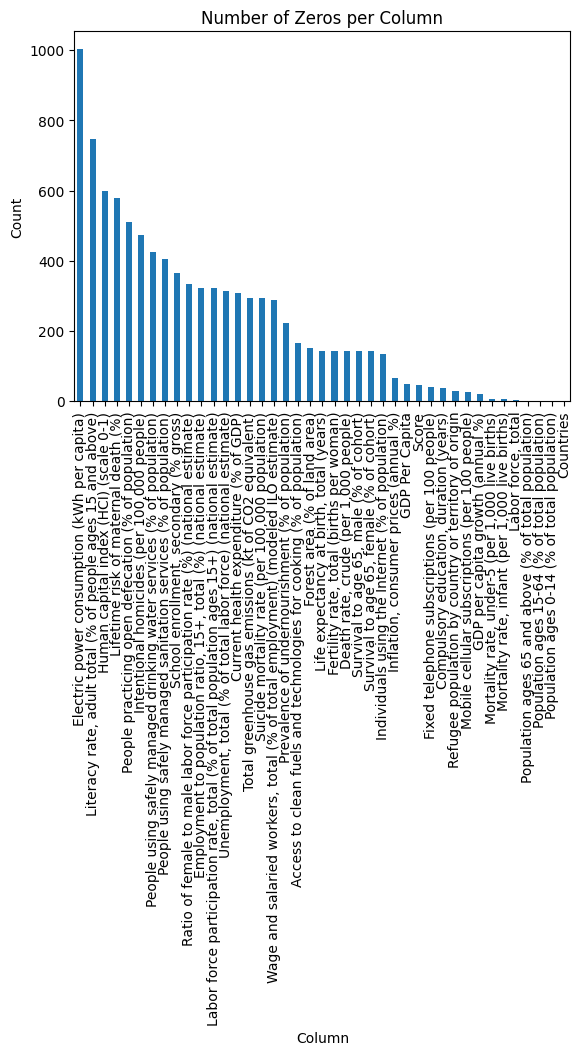

In [120]:
# count number of zeros per column
zeros_per_column = (data == 0).sum()

# plot a bar graph
zeros_per_column=zeros_per_column.sort_values(ascending=False)
zeros_per_column.plot(kind='bar')
plt.title('Number of Zeros per Column')
plt.xlabel('Column')
plt.ylabel('Count')
plt.show()

Observations:

2021 has a lot of missing values (not interesting to study). We choose to drop it. We also drop the 8 columns with the most missing values)

In [121]:

data=data.drop(columns=["Electric power consumption (kWh per capita)",
                        "Literacy rate, adult total (% of people ages 15 and above)",
                        "Human capital index (HCI) (scale 0-1)",
                        "Lifetime risk of maternal death (%)",
                        "People practicing open defecation (% of population)",
                        "Intentional homicides (per 100,000 people)",
                        "People using safely managed drinking water services (% of population)",
                        "People using safely managed sanitation services (% of population)",
                        ]) # Dropping Features that have a lot of missing data
data=data[:-144] # Dropping observations for year 2021
data = data[data['Score'] != 0] # Lastly, dropping all observations that lack a Happiness Score

In [122]:
#Convert into float
cols_to_convert = data.columns.difference(['Countries'])  # Exclude 'countries' column
data[cols_to_convert] = data[cols_to_convert].apply(pd.to_numeric, errors='coerce')
data = data[data['Score'] != 0]

In [123]:
data.tail(147)

Countries  \
716  United States   
717        Uruguay   
718     Uzbekistan   
719      Venezuela   
720        Vietnam   
..             ...   
864      Venezuela   
865        Vietnam   
866          Yemen   
867         Zambia   
868       Zimbabwe   

     Access to clean fuels and technologies for cooking (% of population)  \
716                                              100.0                      
717                                              100.0                      
718                                               84.6                      
719                                               97.0                      
720                                               64.4                      
..                                                 ...                      
864                                               97.0                      
865                                               65.3                      
866                                               61.5                      
867                                               10.4                      
868                                               30.4                      

     Compulsory education, duration (years)  \
716                                      12   
717                                      14   
718                                      12   
719                                      17   
720                                      10   
..                                      ...   
864                                      17   
865                                      10   
866                                       9   
867                                       7   
868                                       7   

     Current health expenditure (% of GDP)  \
716                              16.767063   
717                               9.347832   
718                               5.617604   
719                               5.367084   
720                               5.249656   
..                                     ...   
864                               0.000000   
865                               0.000000   
866                               0.000000   
867                               0.000000   
868                               0.000000   

     Death rate, crude (per 1,000 people)  \
716                                 8.700   
717                                10.057   
718                                 4.600   
719                                 7.017   
720                                 6.706   
..                                    ...   
864                                 7.575   
865                                 6.169   
866                                 6.509   
867                                 6.602   
868                                 8.132   

     Employment to population ratio, 15+, total (%) (national estimate)  \
716                                          60.779999                    
717                                          58.130001                    
718                                          68.139999                    
719                                           0.000000                    
720                                          74.360001                    
..                                                 ...                    
864                                           0.000000                    
865                                          71.739998                    
866                                           0.000000                    
867                                          57.200001                    
868                                           0.000000                    

     Fertility rate, total (births per woman)  \
716                                     1.706   
717                                     1.546   
718                                     2.785   
719                                     2.250   
720           

We impute values using KNN Imputer


In [124]:
# The method works only for numerical variables so we discard the "Countries" column
data_without_countries = data.drop('Countries', axis=1)

# We impute missing values with a K-nearest neighbors type method
imputer = KNNImputer(missing_values = 0, n_neighbors = 5, weights = 'distance')

imputed_data = imputer.fit_transform(data_without_countries)

# We merge back the "Countries" column with the newly formed data to get the new dataframe without any missing values
imputed_data_with_countries = np.column_stack((data['Countries'].to_numpy(),imputed_data))
full_data = pd.DataFrame(imputed_data_with_countries, columns=data.columns)


cols_to_convert = full_data.columns.difference(['Countries'])  # Exclude 'countries' column
full_data[cols_to_convert] = full_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')

#full_data.dtypes

In [125]:
full_data.tail(147) 

Countries  \
676  United States   
677        Uruguay   
678     Uzbekistan   
679      Venezuela   
680        Vietnam   
..             ...   
818      Venezuela   
819        Vietnam   
820          Yemen   
821         Zambia   
822       Zimbabwe   

     Access to clean fuels and technologies for cooking (% of population)  \
676                                              100.0                      
677                                              100.0                      
678                                               84.6                      
679                                               97.0                      
680                                               64.4                      
..                                                 ...                      
818                                               97.0                      
819                                               65.3                      
820                                               61.5                      
821                                               10.4                      
822                                               30.4                      

     Compulsory education, duration (years)  \
676                                    12.0   
677                                    14.0   
678                                    12.0   
679                                    17.0   
680                                    10.0   
..                                      ...   
818                                    17.0   
819                                    10.0   
820                                     9.0   
821                                     7.0   
822                                     7.0   

     Current health expenditure (% of GDP)  \
676                              16.767063   
677                               9.347832   
678                               5.617604   
679                               5.367084   
680                               5.249656   
..                                     ...   
818                               3.842850   
819                               4.450903   
820                               5.089111   
821                               9.410504   
822                               5.844944   

     Death rate, crude (per 1,000 people)  \
676                                 8.700   
677                                10.057   
678                                 4.600   
679                                 7.017   
680                                 6.706   
..                                    ...   
818                                 7.575   
819                                 6.169   
820                                 6.509   
821                                 6.602   
822                                 8.132   

     Employment to population ratio, 15+, total (%) (national estimate)  \
676                                          60.779999                    
677                                          58.130001                    
678                                          68.139999                    
679                                          47.760140                    
680                                          74.360001                    
..                                                 ...                    
818                                          47.372496                    
819                                          71.739998                    
820                                          54.454838                    
821                                          57.200001                    
822                                          58.857959                    

     Fertility rate, total (births per woman)  \
676                                     1.706   
677                                     1.546   
678                                     2.785   
679                                     2.250   
680           

In [126]:
full_data.corr()

Access to clean fuels and technologies for cooking (% of population)  \
Access to clean fuels and technologies for cook...                                           1.000000                      
Compulsory education, duration (years)                                                       0.432884                      
Current health expenditure (% of GDP)                                                        0.301166                      
Death rate, crude (per 1,000 people)                                                         0.026599                      
Employment to population ratio, 15+, total (%) ...                                          -0.078075                      
Fertility rate, total (births per woman)                                                    -0.799540                      
Fixed telephone subscriptions (per 100 people)                                               0.626004                      
Forest area (% of land area)                                                                 0.027859                      
GDP per capita growth (annual %)                                                            -0.000683                      
Individuals using the Internet (% of population)                                             0.819279                      
Inflation, consumer prices (annual %)                                                       -0.078520                      
Labor force participation rate, total (% of tot...                                          -0.046042                      
Labor force, total                                                                           0.002918                      
Life expectancy at birth, total (years)                                                      0.808476                      
Mobile cellular subscriptions (per 100 people)                                               0.546344                      
Mortality rate, infant (per 1,000 live births)                                              -0.823156                      
Mortality rate, under-5 (per 1,000 live births)                                             -0.822730                      
Population ages 0-14 (% of total population)                                                -0.808648                      
Population ages 15-64 (% of total population)                                                0.723610                      
Population ages 65 and above (% of total popula...                                           0.626130                      
Prevalence of undernourishment (% of population)                                            -0.599377                      
Ratio of female to male labor force participati...                                           0.069777                      
Refugee population by country or territory of o...                                          -0.176363                      
School enrollment, secondary (% gross)                                                       0.634535                      
Suicide mortality rate (per 100,000 population)                                              0.157618                      
Survival to age 65, female (% of cohort)                                                     0.818433                      
Survival to age 65, male (% of cohort)                                                       0.724848                      
Total greenhouse gas emissions (kt of CO2 equiv...                                           0.086026                      
Unemployment, total (% of total labor force) (n...                                           0.120947                      
Wage and salaried workers, total (% of total em...                                           0.792121                      
GDP Per Capita                                                                               0.857890                      
Score                                                                               

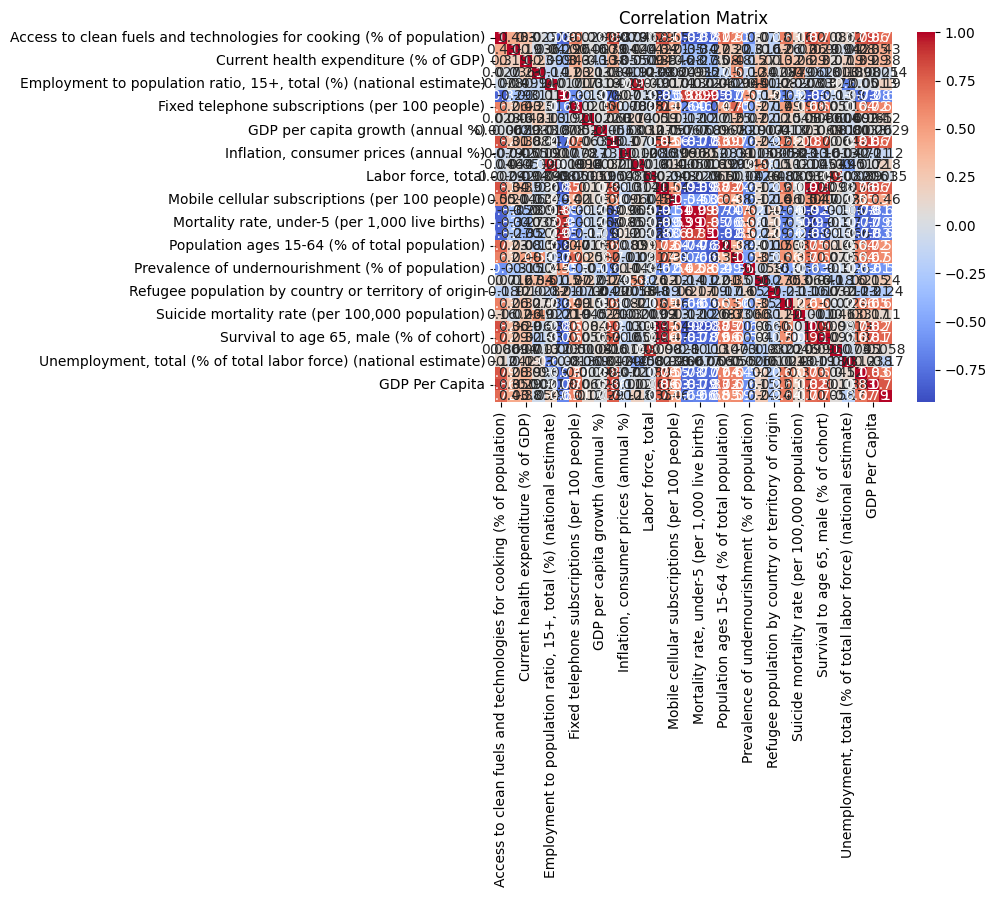

Ranking of columns based on importance in predicting Score:
1. Score
2. GDP Per Capita
3. Life expectancy at birth, total (years)
4. Individuals using the Internet (% of population)
5. Survival to age 65, male (% of cohort)
6. Access to clean fuels and technologies for cooking (% of population)
7. Survival to age 65, female (% of cohort)
8. Mortality rate, infant (per 1,000 live births)
9. Population ages 0-14 (% of total population)
10. Wage and salaried workers, total (% of total employment) (modeled ILO estimate)
11. Mortality rate, under-5 (per 1,000 live births)
12. Fertility rate, total (births per woman)
13. School enrollment, secondary (% gross)
14. Fixed telephone subscriptions (per 100 people)
15. Population ages 65 and above (% of total population)
16. Prevalence of undernourishment (% of population)
17. Population ages 15-64 (% of total population)
18. Mobile cellular subscriptions (per 100 people)
19. Compulsory education, duration (years)
20. Current health expenditure (%

In [127]:
import seaborn as sns
correlation_matrix = full_data.corr()
correlation_matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()
corr_with_score = correlation_matrix["Score"].abs().sort_values(ascending=False)
importance = list(corr_with_score.index)
print("Ranking of columns based on importance in predicting Score:")
for i, feature in enumerate(importance):
   print(f"{i+1}. {feature}")

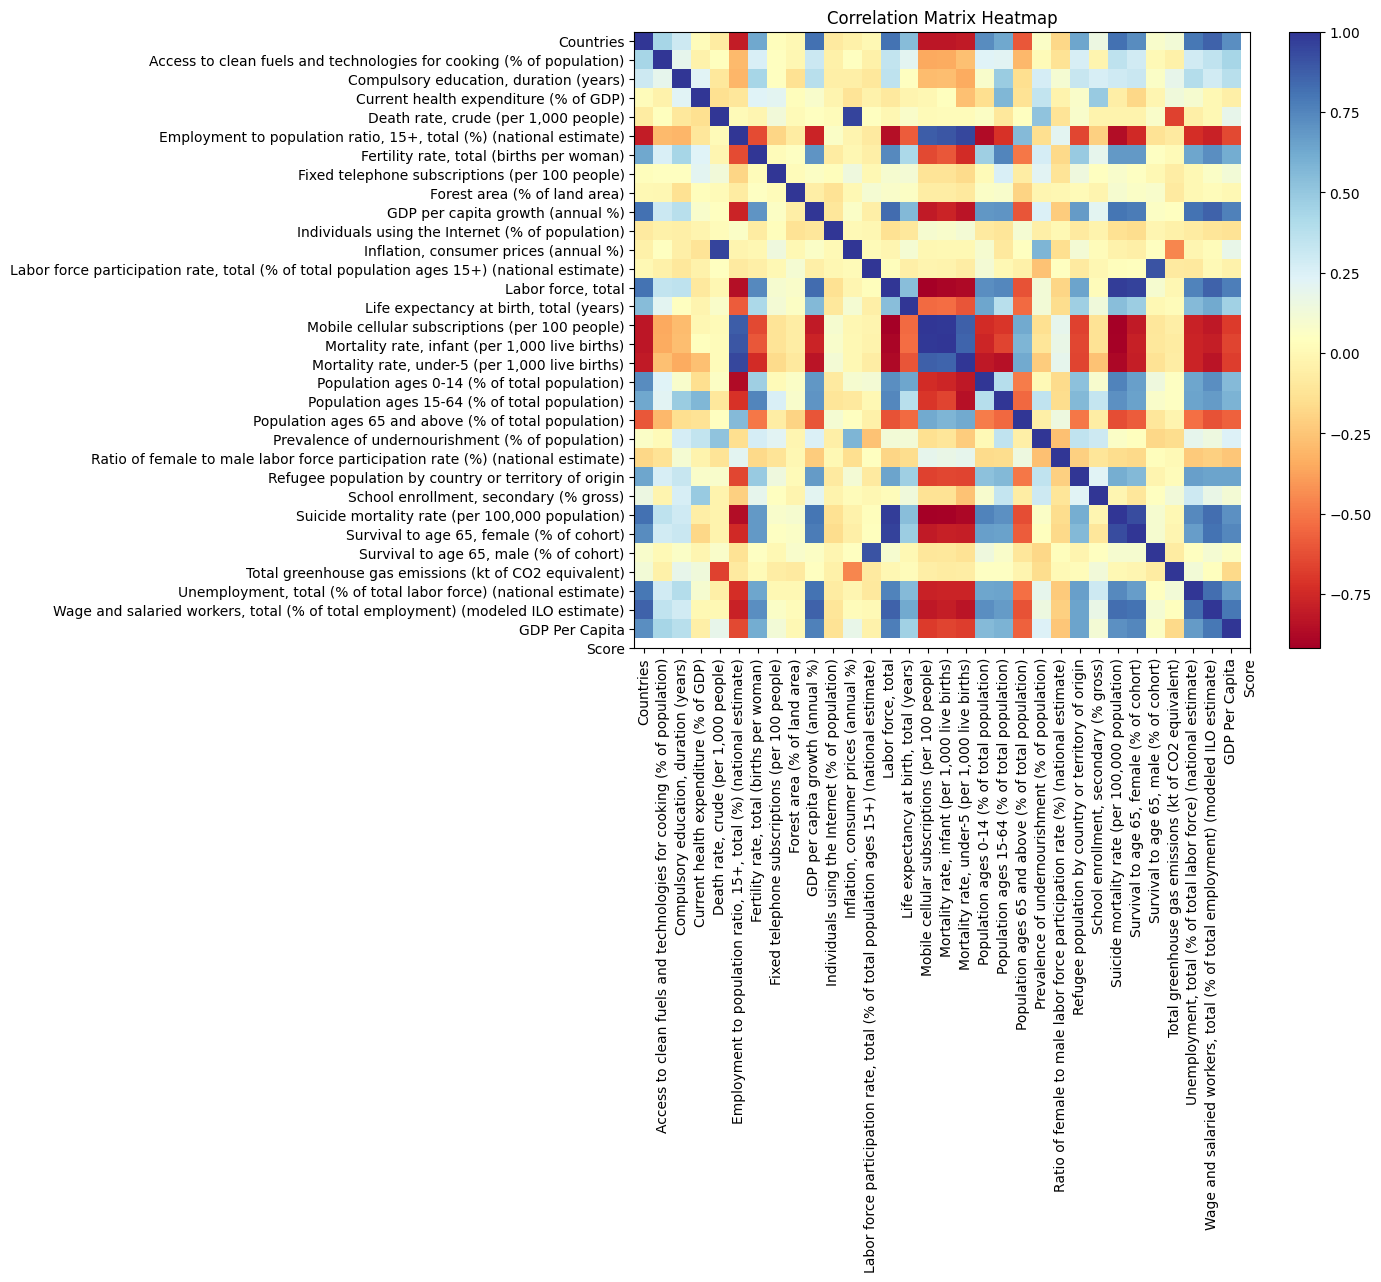

In [128]:
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='RdYlBu', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix Heatmap')
plt.xticks(np.arange(len(data.columns)), data.columns, rotation=90)
plt.yticks(np.arange(len(data.columns)), data.columns)
plt.show()

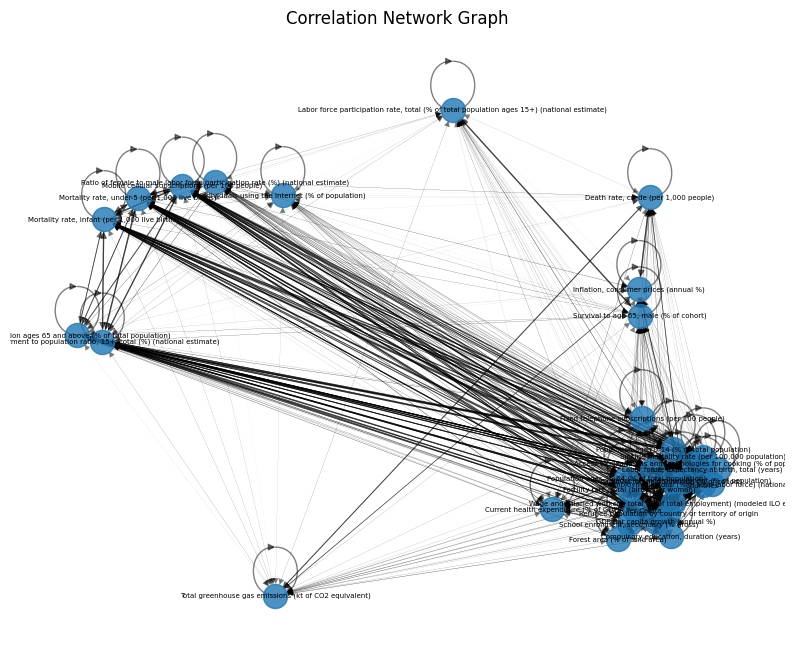

In [129]:
import networkx as nx
G = nx.DiGraph(np.array(correlation_matrix))
pos = nx.spring_layout(G)
labels = {i: factor for i, factor in enumerate(data.columns)}
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=300, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=correlation_matrix.values.flatten(), alpha=0.5)
nx.draw_networkx_labels(G, pos, {k: labels[k] for k in pos}, font_size=5)
plt.title('Correlation Network Graph')
plt.axis('off')
plt.show()

Let us try to make it more readable:

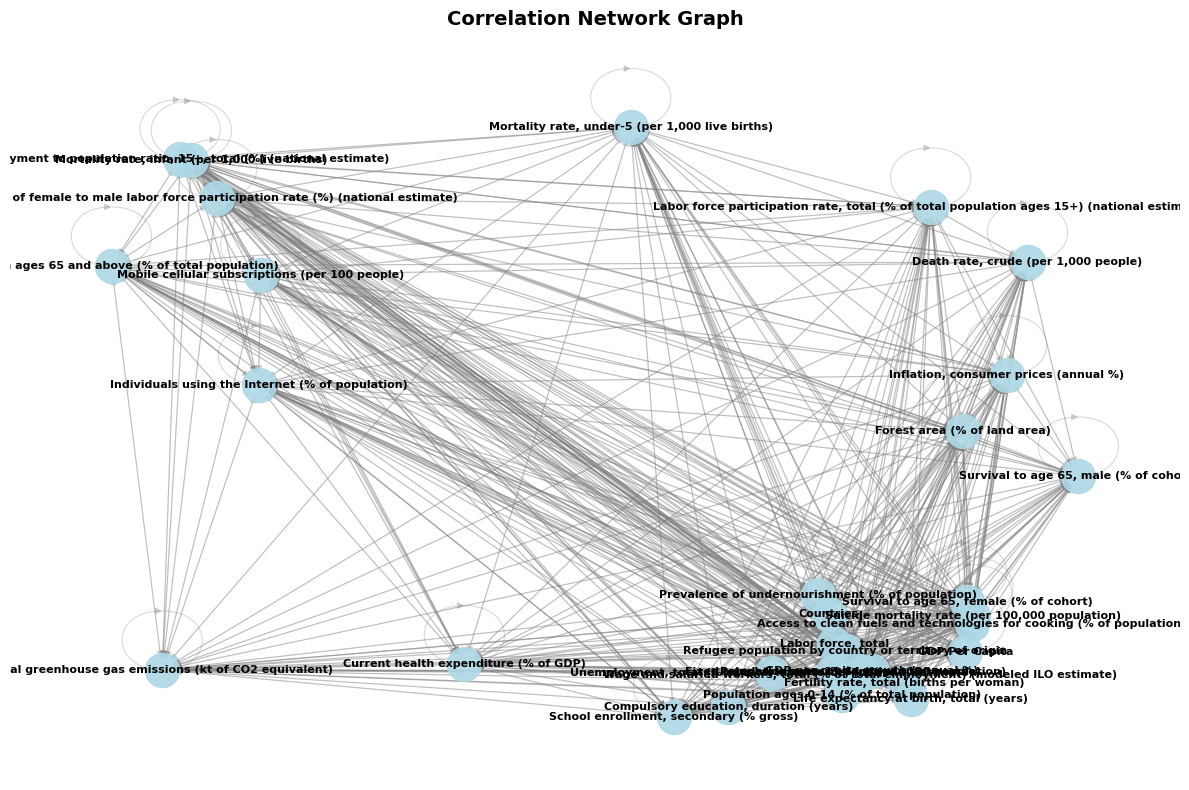

In [130]:
G = nx.DiGraph(np.array(correlation_matrix))
pos = nx.spring_layout(G, seed=42) 
labels = {i: factor for i, factor in enumerate(data.columns)}
plt.figure(figsize=(12, 8)) 
nx.draw_networkx_nodes(G, pos, node_size=600, alpha=0.9, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.3, edge_color='gray')
nx.draw_networkx_labels(G, pos, {k: labels[k] for k in pos}, font_size=8, font_weight='bold')
plt.title('Correlation Network Graph', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

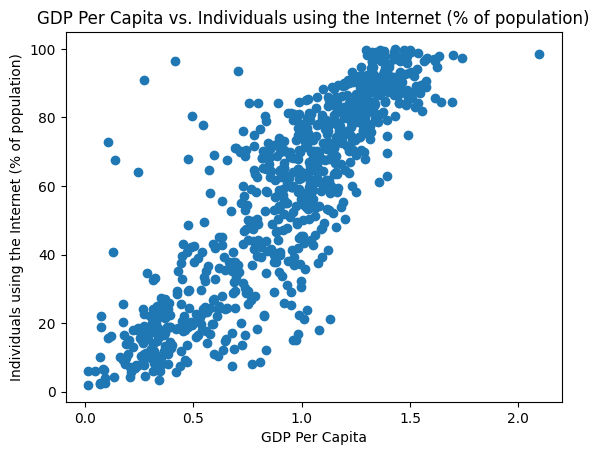

In [131]:
plt.scatter(full_data["GDP Per Capita"], full_data["Individuals using the Internet (% of population)"])
plt.xlabel("GDP Per Capita")
plt.ylabel("Individuals using the Internet (% of population)")
plt.title("GDP Per Capita vs. Individuals using the Internet (% of population)")
plt.show()

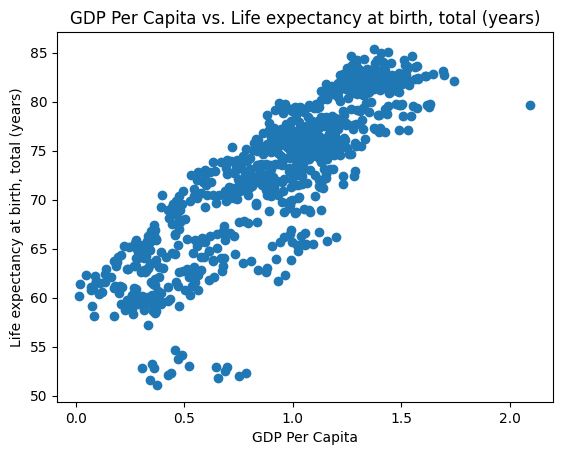

In [132]:
plt.scatter(full_data["GDP Per Capita"], full_data["Life expectancy at birth, total (years)"])
plt.xlabel("GDP Per Capita")
plt.ylabel("Life expectancy at birth, total (years)")
plt.title("GDP Per Capita vs. Life expectancy at birth, total (years)")
plt.show()

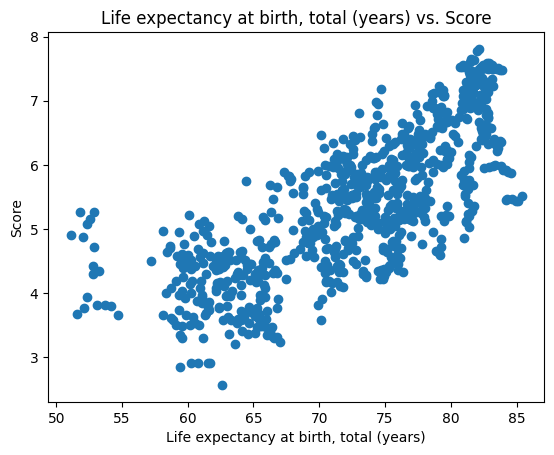

In [133]:
plt.scatter(full_data["Life expectancy at birth, total (years)"], full_data["Score"])
plt.xlabel("Life expectancy at birth, total (years)")
plt.ylabel("Score")
plt.title("Life expectancy at birth, total (years) vs. Score")
plt.show()

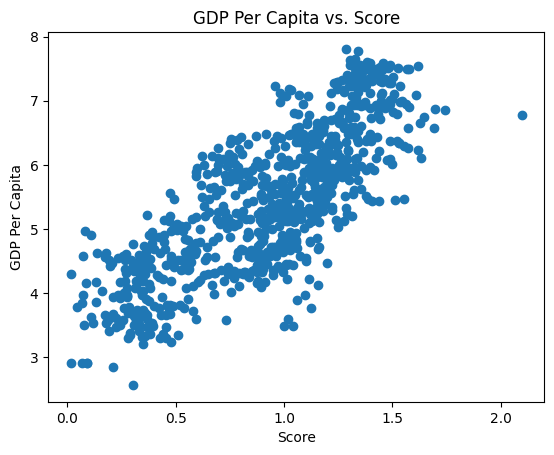

In [134]:
plt.scatter(full_data["GDP Per Capita"], full_data["Score"])
plt.xlabel("Score")
plt.ylabel("GDP Per Capita")
plt.title("GDP Per Capita vs. Score")
plt.show()

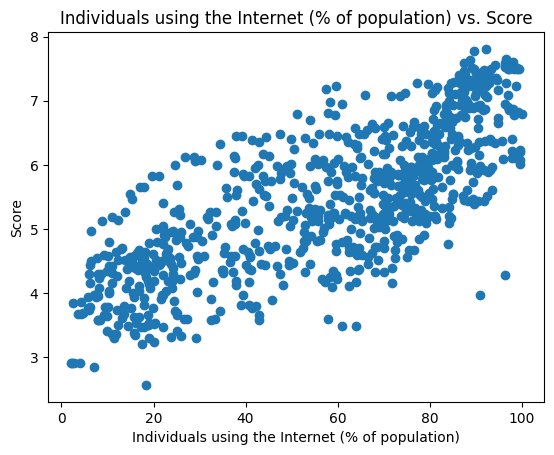

In [135]:
plt.scatter(full_data["Individuals using the Internet (% of population)"], full_data["Score"])
plt.xlabel("Individuals using the Internet (% of population)")
plt.ylabel("Score")
plt.title("Individuals using the Internet (% of population) vs. Score")
plt.show()

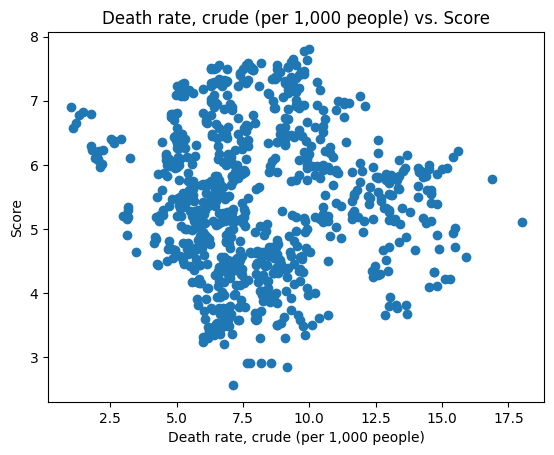

In [136]:
plt.scatter(full_data["Death rate, crude (per 1,000 people)"], full_data["Score"])
plt.xlabel("Death rate, crude (per 1,000 people)")
plt.ylabel("Score")
plt.title("Death rate, crude (per 1,000 people) vs. Score")
plt.show()

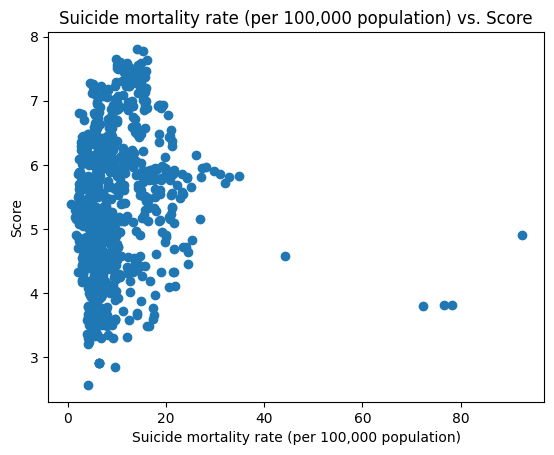

In [137]:
plt.scatter(full_data["Suicide mortality rate (per 100,000 population)"], full_data["Score"])
plt.xlabel("Suicide mortality rate (per 100,000 population)")
plt.ylabel("Score")
plt.title("Suicide mortality rate (per 100,000 population) vs. Score")
plt.show()

Access to clean fuels and technologies for cooking (% of population)  \
count                                         823.000000                      
mean                                           69.659832                      
std                                            36.332553                      
min                                             0.200000                      
25%                                            42.150000                      
50%                                            88.100000                      
75%                                           100.000000                      
max                                           100.000000                      

       Compulsory education, duration (years)  \
count                              823.000000   
mean                                10.051186   
std                                  2.395477   
min                                  5.000000   
25%                                  9.000000   
50%                                 10.000000   
75%                                 12.000000   
max                                 17.000000   

       Current health expenditure (% of GDP)  \
count                             823.000000   
mean                                6.795981   
std                                 2.506380   
min                                 1.936492   
25%                                 4.957237   
50%                                 6.651780   
75%                                 8.483531   
max                                20.413414   

       Death rate, crude (per 1,000 people)  \
count                            823.000000   
mean                               8.015463   
std                                2.882243   
min                                1.014000   
25%                                6.115000   
50%                                7.352000   
75%                                9.600000   
max                               18.000000   

       Employment to population ratio, 15+, total (%) (national estimate)  \
count                                         823.000000                    
mean                                           56.978027                    
std                                             9.021567                    
min                                            24.430000                    
25%                                            52.173641                    
50%                                            57.439999                    
75%                                            61.820549                    
max                                            84.839996                    

       Fertility rate, total (births per woman)  \
count                                823.000000   
mean                                   2.578566   
std                                    1.298570   
min                                    0.868000   
25%                                    1.594000   
50%                                    2.097000   
75%                                    3.145000   
max                                    7.211000   

       Fixed telephone subscriptions (per 100 people)  \
count                                      823.000000   
mean                                        16.824269   
std                                         15.558053   
min                                          0.002295   
25%                                          3.317197   
50%                                         13.627992   
75%                                         26.152815   
max                                         61.007900   

       Forest area (% of land area)  GDP per capita growth (annual %)  \
count                    823.000000                        823.000000   
mean                      28.814393                          0.705503   
std                       20.205364                          4.678232   
min                        0.045186 

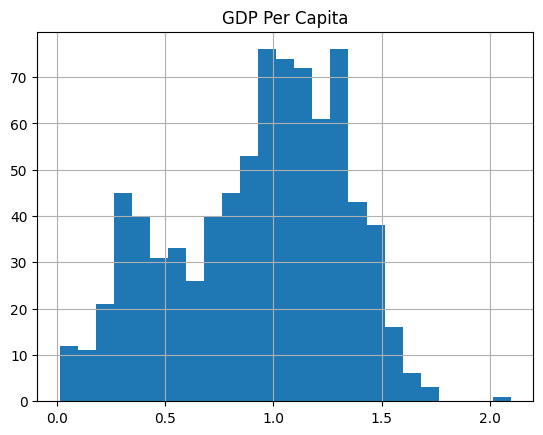

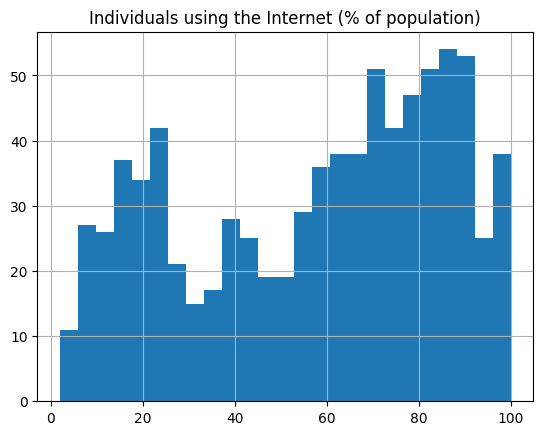

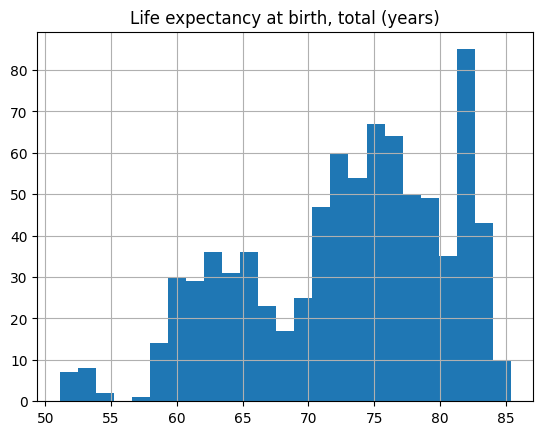

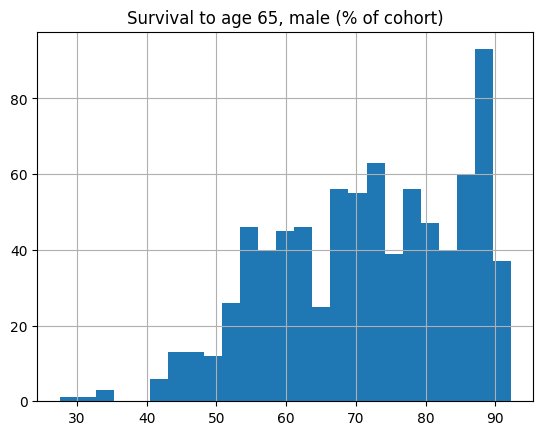

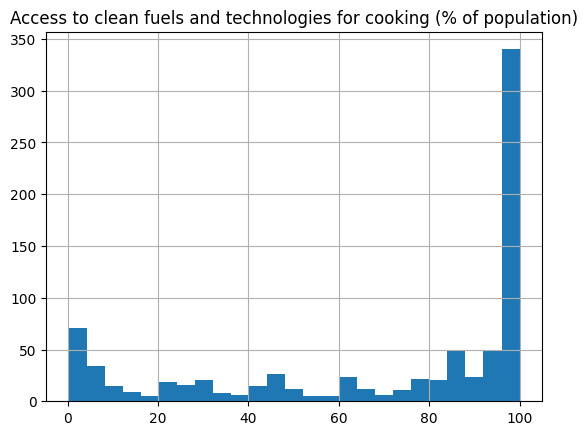

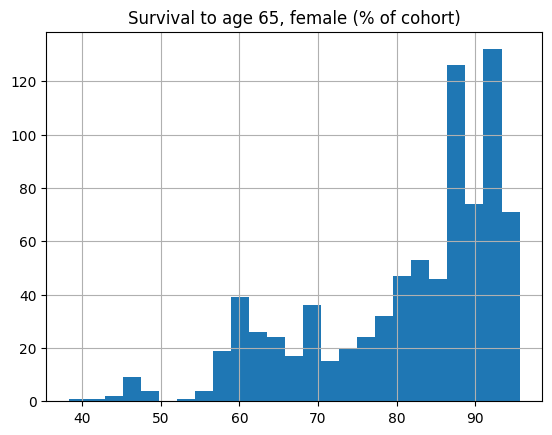

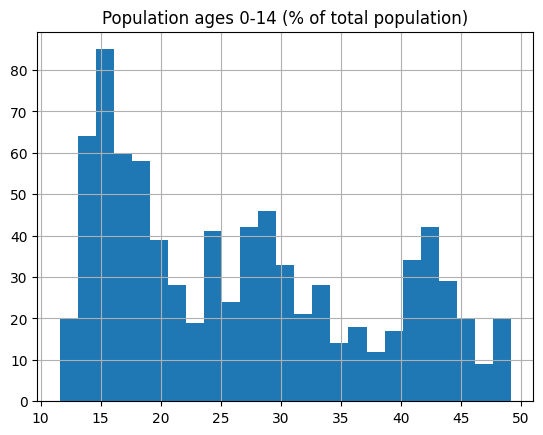

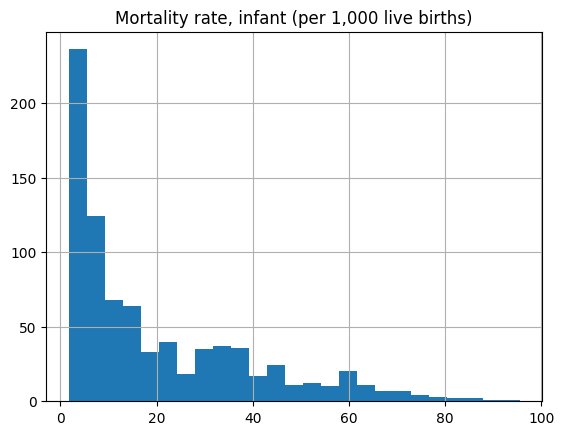

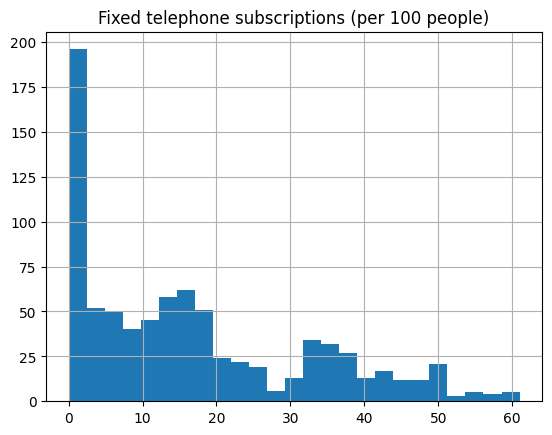

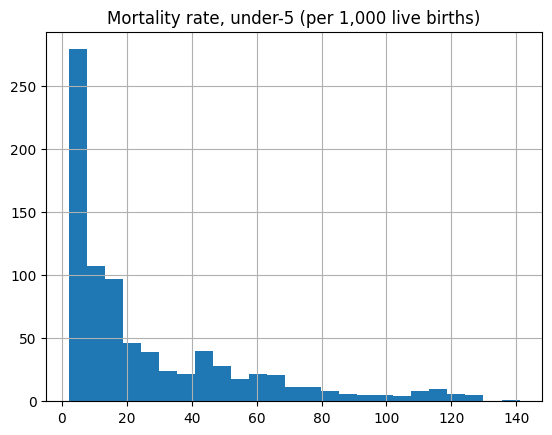

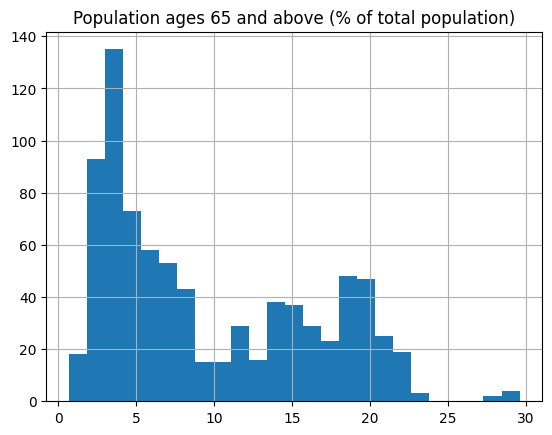

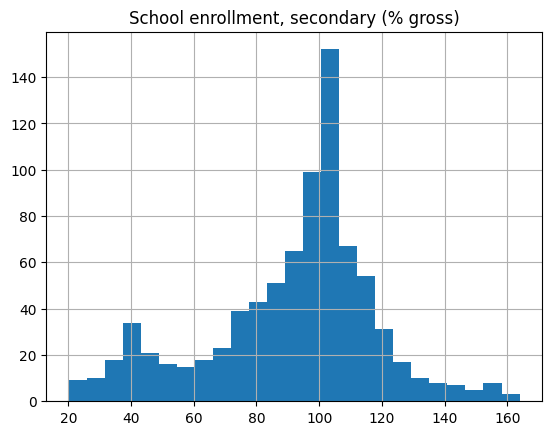

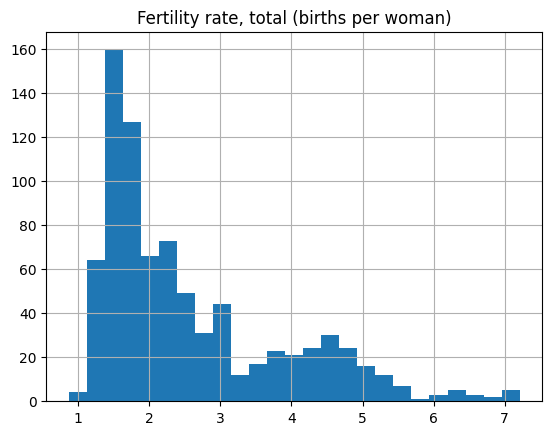

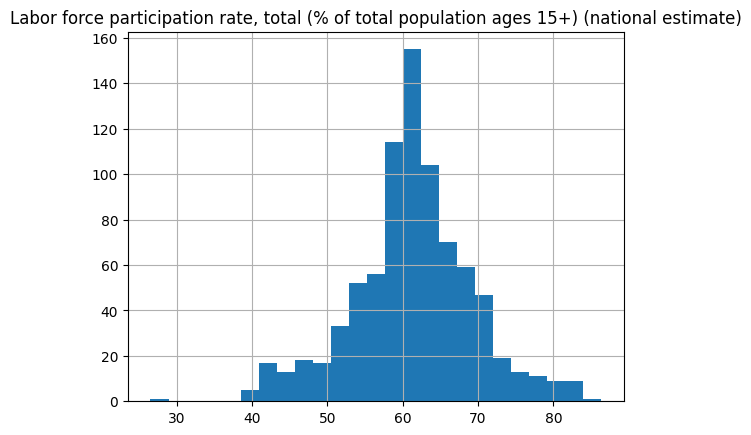

In [138]:
display(full_data.describe())
for var in ["GDP Per Capita", "Individuals using the Internet (% of population)", "Life expectancy at birth, total (years)",
            "Survival to age 65, male (% of cohort)", "Access to clean fuels and technologies for cooking (% of population)",
            "Survival to age 65, female (% of cohort)","Population ages 0-14 (% of total population)","Mortality rate, infant (per 1,000 live births)",
            "Fixed telephone subscriptions (per 100 people)","Mortality rate, under-5 (per 1,000 live births)","Population ages 65 and above (% of total population)",
            "School enrollment, secondary (% gross)","Fertility rate, total (births per woman)",
            "Labor force participation rate, total (% of total population ages 15+) (national estimate)"]:
    full_data.hist(column=var,bins=25)
    plt.show()

Access to clean fuels and technologies for cooking (% of population)  \
count                                         823.000000                      
mean                                           69.659832                      
std                                            36.332553                      
min                                             0.200000                      
25%                                            42.150000                      
50%                                            88.100000                      
75%                                           100.000000                      
max                                           100.000000                      

       Compulsory education, duration (years)  \
count                              823.000000   
mean                                10.051186   
std                                  2.395477   
min                                  5.000000   
25%                                  9.000000   
50%                                 10.000000   
75%                                 12.000000   
max                                 17.000000   

       Current health expenditure (% of GDP)  \
count                             823.000000   
mean                                6.795981   
std                                 2.506380   
min                                 1.936492   
25%                                 4.957237   
50%                                 6.651780   
75%                                 8.483531   
max                                20.413414   

       Death rate, crude (per 1,000 people)  \
count                            823.000000   
mean                               8.015463   
std                                2.882243   
min                                1.014000   
25%                                6.115000   
50%                                7.352000   
75%                                9.600000   
max                               18.000000   

       Employment to population ratio, 15+, total (%) (national estimate)  \
count                                         823.000000                    
mean                                           56.978027                    
std                                             9.021567                    
min                                            24.430000                    
25%                                            52.173641                    
50%                                            57.439999                    
75%                                            61.820549                    
max                                            84.839996                    

       Fertility rate, total (births per woman)  \
count                                823.000000   
mean                                   2.578566   
std                                    1.298570   
min                                    0.868000   
25%                                    1.594000   
50%                                    2.097000   
75%                                    3.145000   
max                                    7.211000   

       Fixed telephone subscriptions (per 100 people)  \
count                                      823.000000   
mean                                        16.824269   
std                                         15.558053   
min                                          0.002295   
25%                                          3.317197   
50%                                         13.627992   
75%                                         26.152815   
max                                         61.007900   

       Forest area (% of land area)  GDP per capita growth (annual %)  \
count                    823.000000                        823.000000   
mean                      28.814393                          0.705503   
std                       20.205364                          4.678232   
min                        0.045186 

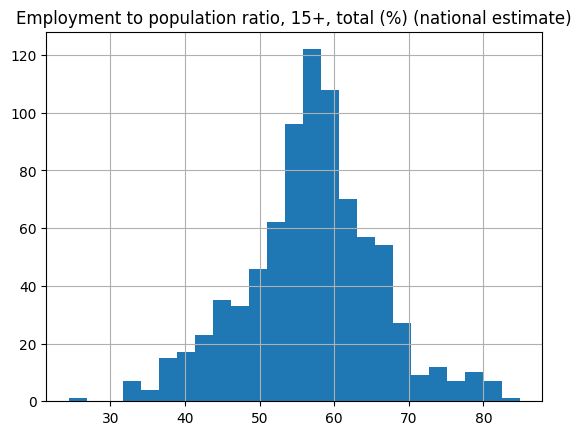

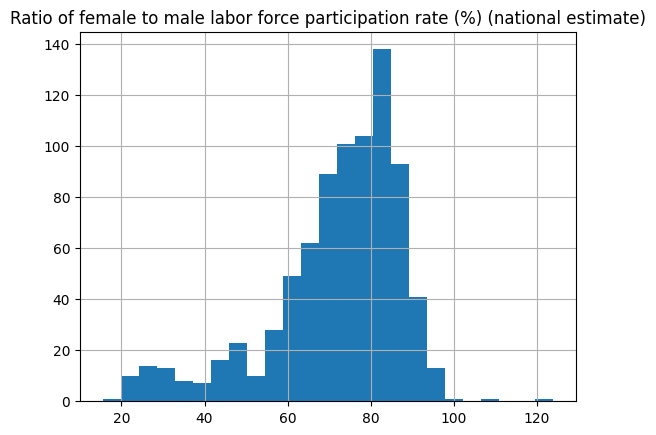

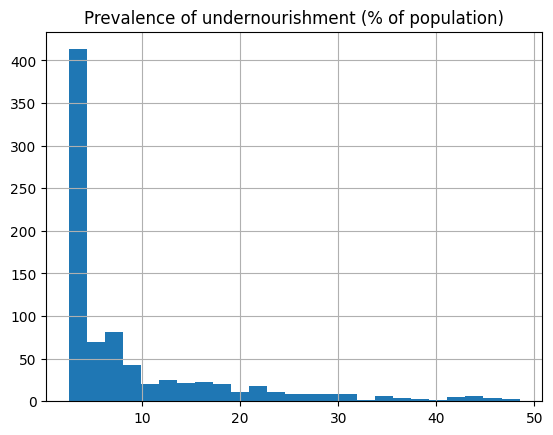

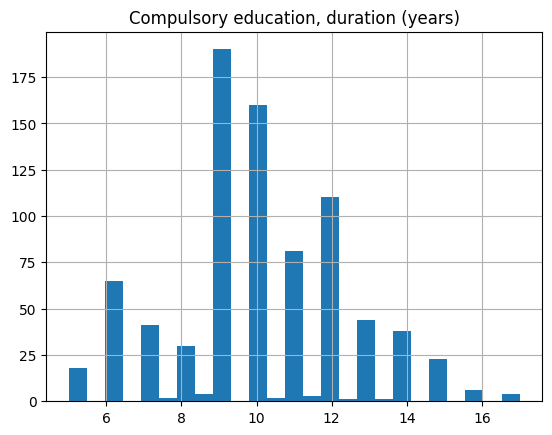

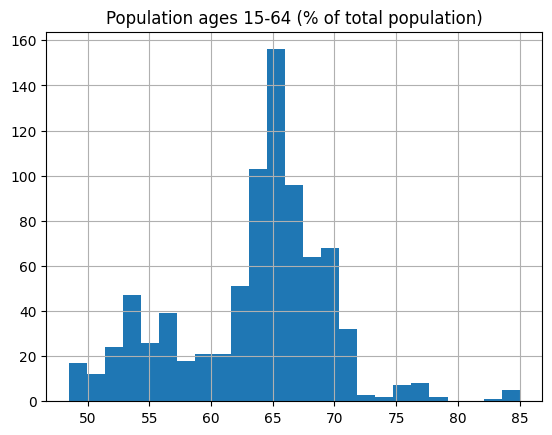

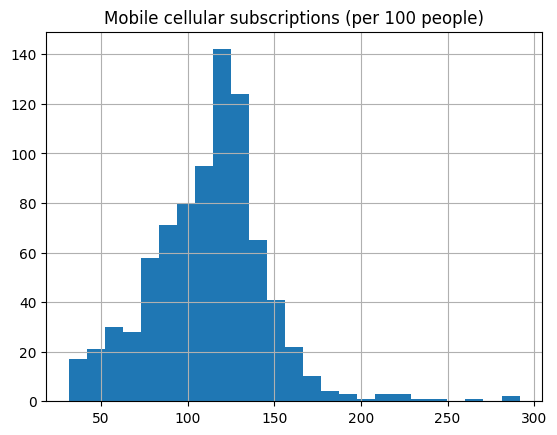

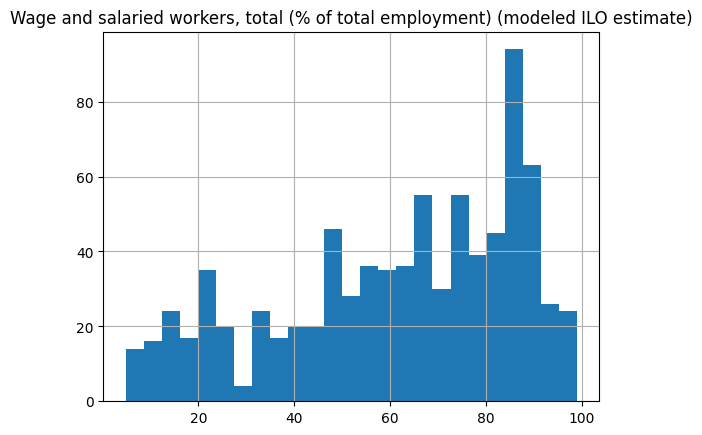

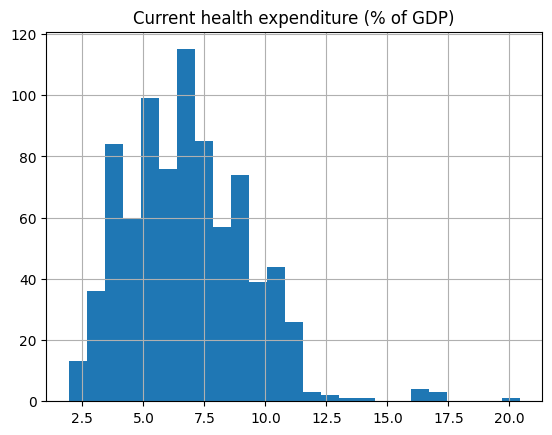

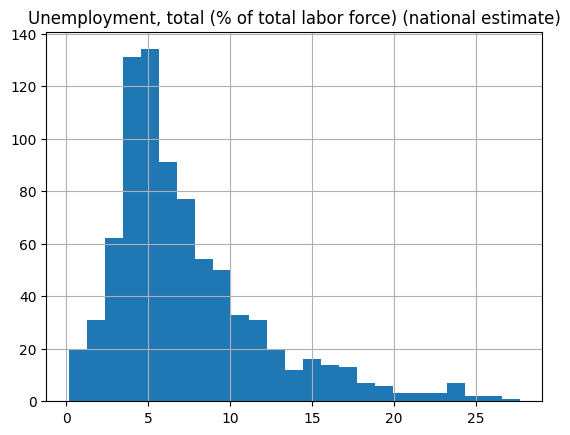

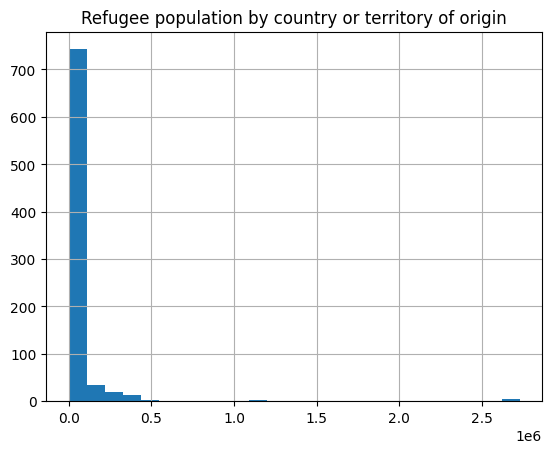

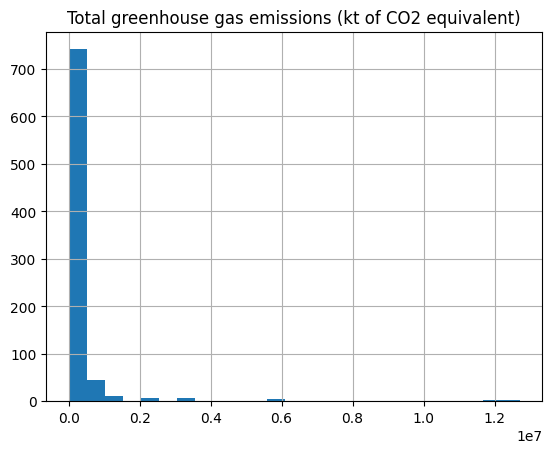

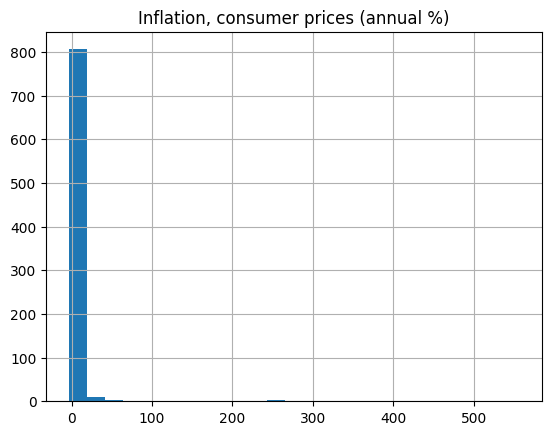

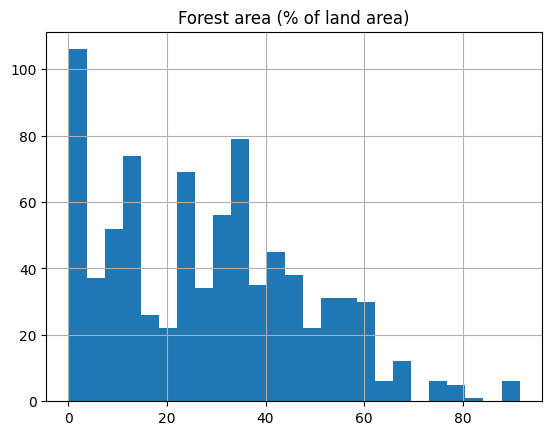

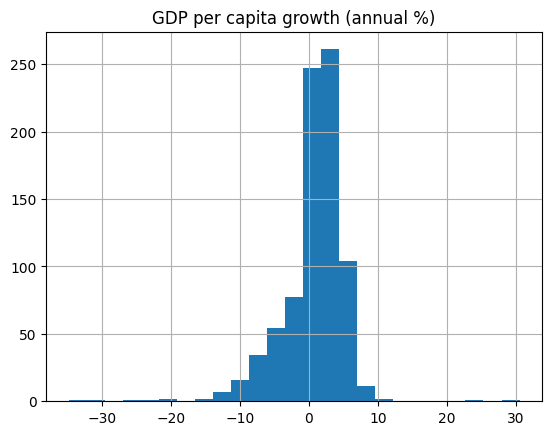

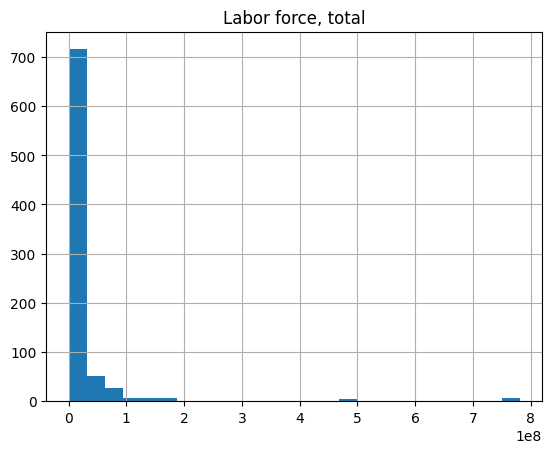

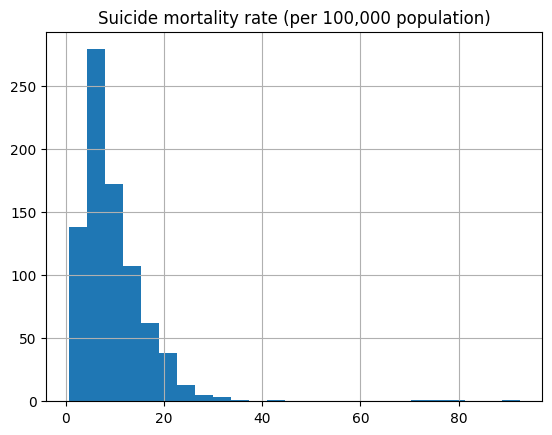

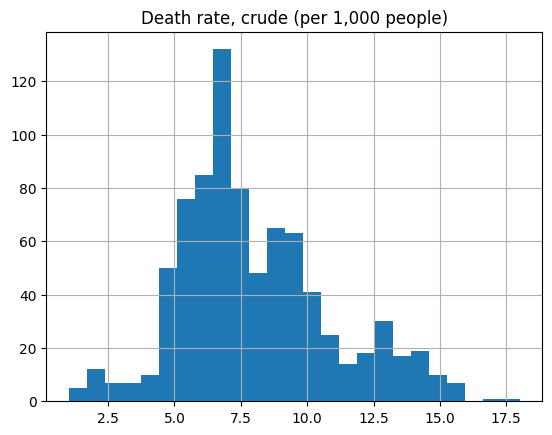

In [139]:
display(full_data.describe())
for var in ["Employment to population ratio, 15+, total (%) (national estimate)", "Ratio of female to male labor force participation rate (%) (national estimate)", 
            "Prevalence of undernourishment (% of population)","Compulsory education, duration (years)", "Population ages 15-64 (% of total population)",
            "Mobile cellular subscriptions (per 100 people)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",
            "Current health expenditure (% of GDP)","Unemployment, total (% of total labor force) (national estimate)","Refugee population by country or territory of origin",
            "Total greenhouse gas emissions (kt of CO2 equivalent)","Inflation, consumer prices (annual %)","Forest area (% of land area)",
            "GDP per capita growth (annual %)","Labor force, total","Suicide mortality rate (per 100,000 population)","Death rate, crude (per 1,000 people)"]:
    full_data.hist(column=var,bins=25)
    plt.show()

### Models

In [140]:
full_data.describe()

Access to clean fuels and technologies for cooking (% of population)  \
count                                         823.000000                      
mean                                           69.659832                      
std                                            36.332553                      
min                                             0.200000                      
25%                                            42.150000                      
50%                                            88.100000                      
75%                                           100.000000                      
max                                           100.000000                      

       Compulsory education, duration (years)  \
count                              823.000000   
mean                                10.051186   
std                                  2.395477   
min                                  5.000000   
25%                                  9.000000   
50%                                 10.000000   
75%                                 12.000000   
max                                 17.000000   

       Current health expenditure (% of GDP)  \
count                             823.000000   
mean                                6.795981   
std                                 2.506380   
min                                 1.936492   
25%                                 4.957237   
50%                                 6.651780   
75%                                 8.483531   
max                                20.413414   

       Death rate, crude (per 1,000 people)  \
count                            823.000000   
mean                               8.015463   
std                                2.882243   
min                                1.014000   
25%                                6.115000   
50%                                7.352000   
75%                                9.600000   
max                               18.000000   

       Employment to population ratio, 15+, total (%) (national estimate)  \
count                                         823.000000                    
mean                                           56.978027                    
std                                             9.021567                    
min                                            24.430000                    
25%                                            52.173641                    
50%                                            57.439999                    
75%                                            61.820549                    
max                                            84.839996                    

       Fertility rate, total (births per woman)  \
count                                823.000000   
mean                                   2.578566   
std                                    1.298570   
min                                    0.868000   
25%                                    1.594000   
50%                                    2.097000   
75%                                    3.145000   
max                                    7.211000   

       Fixed telephone subscriptions (per 100 people)  \
count                                      823.000000   
mean                                        16.824269   
std                                         15.558053   
min                                          0.002295   
25%                                          3.317197   
50%                                         13.627992   
75%                                         26.152815   
max                                         61.007900   

       Forest area (% of land area)  GDP per capita growth (annual %)  \
count                    823.000000                        823.000000   
mean                      28.814393                          0.705503   
std                       20.205364                          4.678232   
min                        0.045186 

The data is not **normalized**, hence we use a scaling function (we chose to use RobustScaler from Scikit learn)

In [141]:
#Training Data

X=full_data.drop(columns=["Score","Countries"],axis=1)
y=full_data["Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
linear_regression = LinearRegression()

linear_regression.fit(X_train_scaled, y_train)

y_pred = linear_regression.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error (MSE) For Linear Regression:", mse)

print("Mean Absolute Error (MAE)For Linear Regression:", mae)


Mean Squared Error (MSE) For Linear Regression: 0.27993570236620274
Mean Absolute Error (MAE)For Linear Regression: 0.4196652564860049


In [143]:
#Ridge regression 
ridge_model = Ridge(alpha=1.0)  
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge=mean_absolute_error(y_test, y_pred_ridge)

#Lasso regression
lasso_model = Lasso(alpha=1.0)  
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso=mean_absolute_error(y_test, y_pred_lasso)

print("Mean Squared Error (MSE) - Ridge Regression:", mse_ridge)
print("Mean Absolute Error (MAE) - Ridge Regression:", mae_ridge)

print("Mean Squared Error (MSE) - Lasso Regression:", mse_lasso)
print("Mean Absolute Error (MAE) - Lasso Regression:", mae_lasso)


Mean Squared Error (MSE) - Ridge Regression: 0.28952036351375227
Mean Absolute Error (MAE) - Ridge Regression: 0.42654257615850394
Mean Squared Error (MSE) - Lasso Regression: 0.8765919036264572
Mean Absolute Error (MAE) - Lasso Regression: 0.7633678209479647


In [144]:
#Cross Validation for Ridge and Lasso

#Ridge
listofalphas=[]
i=0.001
while i<=10:
    listofalphas.append(i)
    i+=0.001
    
ridge_model_cv = RidgeCV(alphas=listofalphas) 
ridge_model_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model_cv.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge=mean_absolute_error(y_test, y_pred_ridge)
print("Best alpha for Ridge regression:", ridge_model_cv.alpha_)
print("Mean Squared Error (MSE) - Ridge Regression:", mse_ridge)
print("Mean Absolute Error (MAE) - Ridge Regression:", mae_ridge)

# Lasso
lasso_model_cv = LassoCV(alphas=[0.001,0.01,0.1,1,10])  
lasso_model_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model_cv.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso=mean_absolute_error(y_test, y_pred_lasso)

print("Best alpha for Lasso regression:", lasso_model_cv.alpha_)
print("Mean Squared Error (MSE) - Lasso Regression:", mse_lasso)
print("Mean Absolute Error (MAE) - Lasso Regression:", mae_lasso)

Best alpha for Ridge regression: 3.658999999999708
Mean Squared Error (MSE) - Ridge Regression: 0.2939483629501764
Mean Absolute Error (MAE) - Ridge Regression: 0.4302050328894518
Best alpha for Lasso regression: 0.001
Mean Squared Error (MSE) - Lasso Regression: 0.28864928776645477
Mean Absolute Error (MAE) - Lasso Regression: 0.42665275126462776


In [145]:
#ElasticNet
enet = ElasticNet()
enet.fit(X_train_scaled, y_train)

y_pred = enet.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error (MSE): 0.725731915528155
Mean Absolute Error (MAE): 0.6959528782940738


In [146]:
#Cross validation for ElasticNet
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [100, 500, 1000, 10000]
}

# Perform grid search with cross-validation
elasticnet_cv = GridSearchCV(enet, param_grid, cv=5, scoring='neg_mean_squared_error')
elasticnet_cv.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = elasticnet_cv.best_params_
print("Best Hyperparameters fro ElasticNet:", best_params)

# Predict on the test set using the best model
y_pred = elasticnet_cv.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error =",mse)
mae=mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)


Best Hyperparameters fro ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 500}
Mean Squared Error = 0.2929120346259215
Mean Absolute Error (MAE): 0.42977335508579856


In [147]:
elasticNet_model=ElasticNet(alpha=0.01,l1_ratio=0.1,max_iter=500)
elasticNet_model.fit(X_train_scaled,y_train)

ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=500)

In [148]:
new_data = full_data.drop(columns=["Countries"])
linear_coeff_magnitudes = linear_regression.coef_
ridge_coeff_magnitudes = ridge_model_cv.coef_
lasso_coeff_magnitudes = lasso_model_cv.coef_
elasticNet_coeff_magnitudes = elasticNet_model.coef_

# Sort the magnitudes and corresponding variable names in descending order for each model
sorted_linear_indices = np.argsort(linear_coeff_magnitudes)[:-1][::-1]  # Exclude the last index corresponding to the dependent variable
sorted_linear_magnitudes = linear_regression.coef_[sorted_linear_indices]
sorted_linear_variable_names = new_data.columns[sorted_linear_indices]

sorted_ridge_indices = np.argsort(ridge_coeff_magnitudes)[:-1][::-1]
sorted_ridge_magnitudes = ridge_model_cv.coef_[sorted_ridge_indices]
sorted_ridge_variable_names = new_data.columns[sorted_ridge_indices]

sorted_lasso_indices = np.argsort(lasso_coeff_magnitudes)[:-1][::-1]
sorted_lasso_magnitudes = lasso_model_cv.coef_[sorted_lasso_indices]
sorted_lasso_variable_names = new_data.columns[sorted_lasso_indices]

sorted_elasticnet_indices = np.argsort(elasticNet_coeff_magnitudes)[:-1][::-1]
sorted_elasticnet_magnitudes = elasticNet_model.coef_[sorted_elasticnet_indices]
sorted_elasticnet_variable_names = new_data.columns[sorted_elasticnet_indices]

# Print the importance ranking for each model
print("Variable Importance - Linear Regression:")
for i, (name, magnitude) in enumerate(zip(sorted_linear_variable_names, sorted_linear_magnitudes), start=1):
    print(f"{i}. {name}: {magnitude}")

print("\nVariable Importance - Ridge Regression:")
for i, (name, magnitude) in enumerate(zip(sorted_ridge_variable_names, sorted_ridge_magnitudes), start=1):
    print(f"{i}. {name}: {magnitude}")

print("\nVariable Importance - Lasso Regression:")
for i, (name, magnitude) in enumerate(zip(sorted_lasso_variable_names, sorted_lasso_magnitudes), start=1):
    print(f"{i}. {name}: {magnitude}")

print("\nVariable Importance - ElasticNet Regression:")
for i, (name, magnitude) in enumerate(zip(sorted_elasticnet_variable_names, sorted_elasticnet_magnitudes), start=1):
    print(f"{i}. {name}: {magnitude}")

Variable Importance - Linear Regression:
1. GDP Per Capita: 0.6183015684014818
2. Mortality rate, under-5 (per 1,000 live births): 0.42483514606125394
3. Survival to age 65, male (% of cohort): 0.3837749252302577
4. Individuals using the Internet (% of population): 0.31667124921178214
5. Access to clean fuels and technologies for cooking (% of population): 0.3036331892556884
6. Population ages 0-14 (% of total population): 0.24510838949350772
7. Current health expenditure (% of GDP): 0.22074753102981637
8. Compulsory education, duration (years): 0.15790375191636563
9. Labor force participation rate, total (% of total population ages 15+) (national estimate): 0.1471939294290264
10. School enrollment, secondary (% gross): 0.11392772367726886
11. Forest area (% of land area): 0.09712846382125816
12. Death rate, crude (per 1,000 people): 0.04961166857518622
13. Suicide mortality rate (per 100,000 population): 0.03319291525313068
14. Total greenhouse gas emissions (kt of CO2 equivalent): -0

We see that apart for Linear Regresion, GDP is important for most of the 

### Tree Methods

In [149]:
decision_tree = DecisionTreeRegressor(random_state=42)

#We directly use Cross Validation


hyperparameters = {'max_depth': range(1, 10), 
                   'min_samples_leaf': range(5, 20, 1)}

grid = GridSearchCV(decision_tree, 
                    param_grid=hyperparameters, 
                    cv=5, 
                    scoring='neg_mean_squared_error')

grid.fit(X_train_scaled, y_train)

print('Best Parameters:', grid.best_params_)

# Make predictions on the test set using the best model
y_pred = grid.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error (MSE) For Decision Tree:", mse)
print("Mean Absolute Error (MAE):", mae)

Best Parameters: {'max_depth': 9, 'min_samples_leaf': 6}
Mean Squared Error (MSE) For Decision Tree: 3.6543479247658275
Mean Absolute Error (MAE): 1.6674769610175542


In [150]:
decision_treeCV=sklearn.tree.DecisionTreeRegressor(**grid.best_params_) #The **unpacks the dictionnary
decision_treeCV.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=9, min_samples_leaf=6)

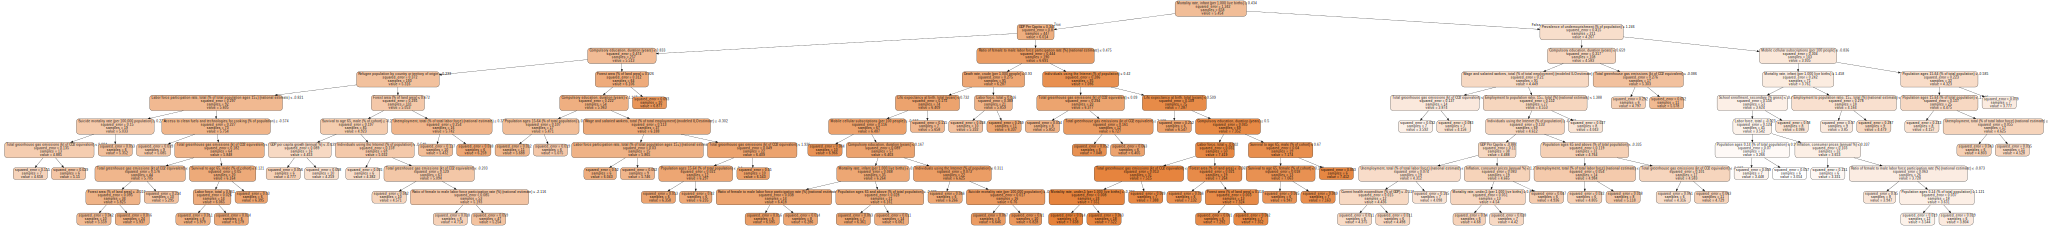

In [163]:
import graphviz
from IPython.display import display

dot_data = sklearn.tree.export_graphviz(decision_treeCV, out_file=None, 
                                        feature_names=X_train.columns,  
                                        filled=True, rounded=True,  
                                        special_characters=True)  

graph = graphviz.Source(dot_data)
graph.format = 'pdf'  # Set the output format to PDF

# Specify the path and filename for saving the PDF
pdf_path = "decisiontree"

# Render and save the tree as a PDF file
graph.render(pdf_path, view=True)
display(graph)

The training part for the Random Forest takes a bit of time. Feel free to skip this part

In [152]:
#Random Forest:

random_forest = RandomForestRegressor(random_state=42)

# We directly use Cross Validation
hyperparameters = {'max_depth': range(1, 10),
                   'min_samples_leaf': range(5, 20, 1)}

grid = GridSearchCV(random_forest,
                    param_grid=hyperparameters,
                    cv=5,
                    scoring='neg_mean_squared_error')

grid.fit(X_train_scaled, y_train)

print('Best Parameters:', grid.best_params_)

# Make predictions on the test set using the best model
y_pred = grid.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error (MSE) For Random Forest:", mse)
print("Mean Absolute Error (MAE):", mae)


Best Parameters: {'max_depth': 9, 'min_samples_leaf': 5}
Mean Squared Error (MSE) For Random Forest: 1.2266656786865449
Mean Absolute Error (MAE): 0.9090161072339505


In [156]:
RandomForestCV=RandomForestRegressor(**grid.best_params_) #The **unpacks the dictionnary
RandomForestCV.fit(X_train_scaled,y_train)

RandomForestRegressor(max_depth=9, min_samples_leaf=5)

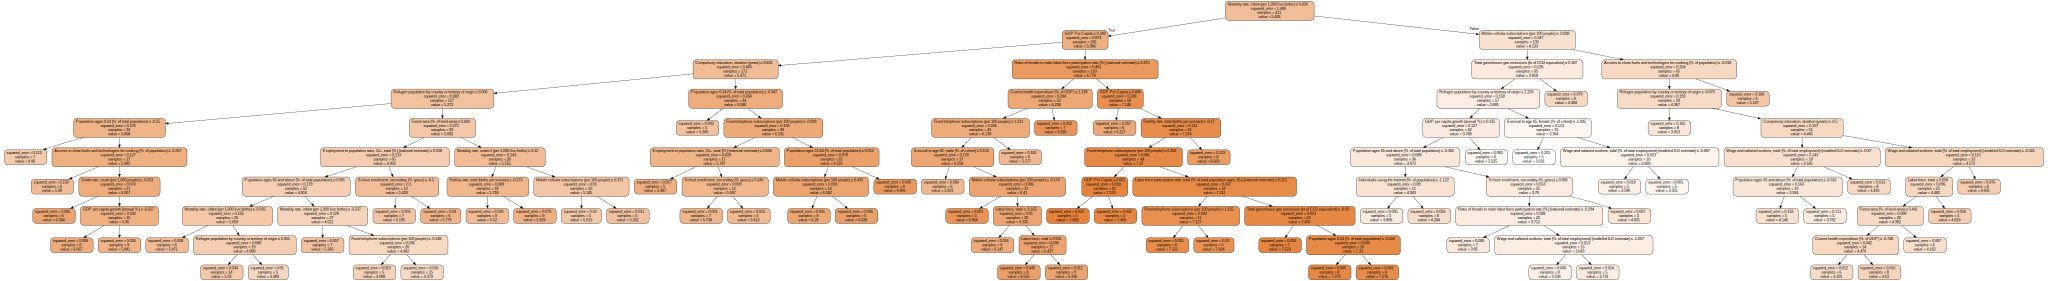

In [164]:
#We visualise one tree (the last one for example
tree_in_forest = RandomForestCV.estimators_[-1]

dot_data = sklearn.tree.export_graphviz(tree_in_forest, out_file=None, 
                                        feature_names=X_train.columns,  
                                        filled=True, rounded=True,  
                                        special_characters=True)  

graph = graphviz.Source(dot_data)
graph.format = 'pdf'  # Set the output format to PDF

# Specify the path and filename for saving the PDF
pdf_path = "rftree"

# Render and save the tree as a PDF file
graph.render(pdf_path, view=True)
display(graph)

In [ ]:
#data.dtypes

In [ ]:
models=[linear_regression,
lasso_model_cv,
ridge_model_cv,
elasticnet_cv]

modelnames=["linear_regression",
"lasso_model_cv",
"ridge_model_cv",
"elasticnet_cv"]

full_data


In [ ]:
afghanistan_rows = full_data[full_data["Countries"] == "Afghanistan"]
#afghanistan_rows
#full_data.tail(145)



In [ ]:
def predicted_ranking(model,year):
  indexx = [0,137,273,410,547,684,823]
  if year <2015 or year > 2020:
    raise ValueError("Year must be between 2015 and 2020.")
  else:
    i = year - 2015
    X_test = full_data.iloc[indexx[i]:indexx[i+1]].copy()
    y_test = X_test['Score']
    countries = X_test['Countries']
    X_test.drop(columns=['Countries', 'Score'], inplace=True)

    X_train = full_data.copy()
    X_train.drop(X_train.index[indexx[i]:indexx[i+1]], inplace=True)
    y_train = X_train['Score']
    X_train.drop(columns=['Countries', 'Score'], inplace=True)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) 
    
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)

    y_test_df = y_test.reset_index().rename(columns={'Score': 'Score'})
    y_test_df['Prediction'] = y_pred
    y_test_df.index = countries
    y_test_df = y_test_df.drop("index", axis=1)

    y_test_df = y_test_df.sort_values("Score",ascending=False)
    ord1 = y_test_df.index.to_numpy()

    y_test_df = y_test_df.sort_values("Prediction",ascending = False)
    ord2 = y_test_df.index.to_numpy()

    delta = np.zeros(len(ord2),dtype=int)
    for i,elem in enumerate(ord2):
      ord1_index = np.where(ord1 == elem)[0][0]
      delta[i] = i - ord1_index
    
    avg_delta = np.mean(np.absolute(delta))

    res = {"Place":range(1,len(ord1)+1),"Actual Ranking":ord1,"Predicted Ranking":ord2,"Delta":delta}
    results = pd.DataFrame(res)
    
    #print(results.head(25))
    #print(results.tail(25))
    #print("The average delta of the prediction is ",avg_delta)
    return results, avg_delta

#mod = lasso_model_cv
#predicted_ranking(mod,2015)

In [ ]:
result,delta = predicted_ranking(LinearRegression(),2016)
print(result)
print("Average delta for Linear Regression is ",delta)

In [ ]:
result,delta = predicted_ranking(elasticnet_cv,2017)
print(result)
print("Average delta for Elastic Net is ",delta)

In [ ]:
result,delta = predicted_ranking(lasso_model_cv,2018)
print(result)
print("Average delta for Lasso Regression is ",delta)

In [ ]:
result,delta = predicted_ranking(ridge_model_cv,2019)
print(result)
print("Average delta for Ridge Regression is ",delta)